# Performance tests: Case 6

Flow: Source -(sourceout)-> Reactor -(reactorout)-> Storage -(coolout)-> Sink

The driving commodity is 'power' with a demand equation of 1000*t*.

This time the facilities 'storage' and 'sink' are supply driven deployed.

In [5]:
import json
import re
import subprocess
import os
import sqlite3 as lite
import copy
import glob
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import d3ploy.tester as tester
import d3ploy.plotter as plotter
import collections

# Delete previously generated files
direc = os.listdir('./')
hit_list = glob.glob('*.sqlite') + glob.glob('*.xml') + glob.glob('*.png') + glob.glob('*.csv') + glob.glob('*.txt')
for file in hit_list:
    os.remove(file)

ENV = dict(os.environ)
ENV['PYTHONPATH'] = ".:" + ENV.get('PYTHONPATH', '')

calc_methods = ["ma", "arma", "arch", "poly", "exp_smoothing", "holt_winters", "fft"]

demand_eq = "1000*t"

control = """
<control>
    <duration>40</duration>
    <startmonth>1</startmonth>
    <startyear>2000</startyear>
</control>"""

archetypes = """
<archetypes>
        <spec>
            <lib>cycamore</lib>
            <name>Source</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>Reactor</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>Storage</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>Sink</name>
        </spec>
        <spec>
            <lib>agents</lib>
            <name>NullRegion</name>
        </spec>
        <spec>
            <lib>agents</lib>
            <name>NullInst</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>DeployInst</name>
        </spec>
        <spec>
            <lib>d3ploy.timeseries_inst</lib>
            <name>TimeSeriesInst</name>
        </spec>
        <spec>
            <lib>d3ploy.supply_driven_deployment_inst</lib>
            <name>SupplyDrivenDeploymentInst</name>
        </spec>
    </archetypes>
"""

source = """
<facility>
    <name>source</name>
    <config>
        <Source>
            <outcommod>sourceout</outcommod>
            <outrecipe>sourceoutrecipe</outrecipe>
            <throughput>2000</throughput>
        </Source>
    </config>
</facility>
"""

reactor = """
<facility>
    <name>reactor</name>
    <config>
      <Reactor>
        <fuel_inrecipes>
            <val>sourceoutrecipe</val>
        </fuel_inrecipes>
        <fuel_outrecipes>
            <val>reactoroutrecipe</val>
        </fuel_outrecipes>
        <fuel_incommods>
            <val>sourceout</val>
        </fuel_incommods>
        <fuel_outcommods>
            <val>reactorout</val>
        </fuel_outcommods>
        <cycle_time>10</cycle_time>
        <refuel_time>0</refuel_time>
        <assem_size>1000</assem_size>
        <n_assem_core>3</n_assem_core>
        <n_assem_batch>1</n_assem_batch>
        <power_cap>1000</power_cap>
      </Reactor>
    </config>
</facility>
"""

storage="""
    <facility>
        <name>storage</name>
        <config>
            <Storage>
                <in_commods>
                    <val>reactorout</val>
                </in_commods>
                <residence_time>10</residence_time>
                <out_commods>
                    <val>coolout</val>
                </out_commods>
                <max_inv_size>1e4</max_inv_size>
            </Storage>
        </config>
    </facility>
"""

sink = """
<facility>
        <name>sink</name>
        <config>
            <Sink>
                <in_commods>
                    <val>coolout</val>
                </in_commods>
                <max_inv_size>1e5</max_inv_size>
            </Sink>
        </config>
    </facility>
"""

region = {}
for calc_method in calc_methods:
    region[calc_method] = """
    <region>
        <config>
            <NullRegion>
            </NullRegion>
        </config>

        <institution>
            <config>
                <TimeSeriesInst>
                    <calc_method>%s</calc_method>
                    <commodities>
                        <val>sourceout_source_2000</val>
                        <val>POWER_reactor_1000</val>
                    </commodities>
                    <driving_commod>POWER</driving_commod>
                    <demand_std_dev>0</demand_std_dev>
                    <demand_eq>%s</demand_eq>
                    <record>1</record>
                    <steps>1</steps>
                </TimeSeriesInst>
            </config>
            <name>source_inst</name>
            </institution>
            
            <institution>
            <config>
                <SupplyDrivenDeploymentInst>
                    <calc_method>%s</calc_method>
                    <commodities>
                        <val>reactorout_storage_1e4</val> 
                        <val>coolout_sink_1e5</val> 
                    </commodities>
                    <capacity_std_dev>0</capacity_std_dev>
                    <record>1</record>
                    <steps>1</steps>
                </SupplyDrivenDeploymentInst>
            </config>
            <name>supply_inst</name>
            </institution>

        <name>SingleRegion</name>
    </region>
    """%(calc_method,demand_eq,calc_method)

recipe = """
<recipe>
   <name>sourceoutrecipe</name>
   <basis>mass</basis>
   <nuclide> <id>U235</id> <comp>0.711</comp> </nuclide>
   <nuclide> <id>U238</id> <comp>99.289</comp> </nuclide>
</recipe>
 
<recipe>
   <name>reactoroutrecipe</name>
   <basis>mass</basis>
   <nuclide> <id>Kr85</id> <comp>50</comp> </nuclide>
   <nuclide> <id>Cs137</id> <comp>50</comp> </nuclide>
</recipe>
 """

metric_dict = {}
for calc_method in calc_methods:

    input_file = 'case6_'+ calc_method +'.xml'
    output_file = 'case6_'+ calc_method +'.sqlite'
    name = 'case6_'+ calc_method +'_power'
    name2 = 'case6_'+ calc_method +'_sourceout'
    name3 = 'case6_'+ calc_method +'_reactorout'
    name4 = 'case6_'+ calc_method +'_coolout'

    with open(input_file, 'w') as f:
        f.write('<simulation>\n')
        f.write(control + archetypes)
        f.write(source + reactor + storage + sink)
        f.write(region[calc_method])
        f.write(recipe)
        f.write('</simulation>')

    s = subprocess.check_output(['cyclus', '-o', output_file, input_file],
                                universal_newlines=True, env=ENV)

    all_dict_power = {}
    all_dict_power = tester.supply_demand_dict_driving(output_file, demand_eq, 'power')
    plotter.plot_demand_supply(all_dict_power, 'power', name, True)
    all_dict_fuel = {} 
    all_dict_fuel = tester.supply_demand_dict_nondriving(output_file, 'sourceout', True)
    plotter.plot_demand_supply(all_dict_fuel, 'sourceout', name2, True)
    all_dict_spentfuel = {} 
    all_dict_spentfuel = tester.supply_demand_dict_nondriving(output_file, 'reactorout', False)
    plotter.plot_demand_supply(all_dict_spentfuel, 'reactorout', name3, False)
    all_dict_coolfuel = {} 
    all_dict_coolfuel = tester.supply_demand_dict_nondriving(output_file, 'coolout', False)
    plotter.plot_demand_supply(all_dict_coolfuel, 'coolout', name4, False)

    metric_dict = tester.metrics(all_dict_power,metric_dict,calc_method,'power',True)
    metric_dict = tester.metrics(all_dict_fuel,metric_dict,calc_method,'sourceout',True)
    metric_dict = tester.metrics(all_dict_spentfuel,metric_dict,calc_method,'reactorout',False)
    metric_dict = tester.metrics(all_dict_coolfuel,metric_dict,calc_method,'coolout',False)
    
    df = pd.DataFrame(metric_dict)
    df.to_csv('case6_output.csv')


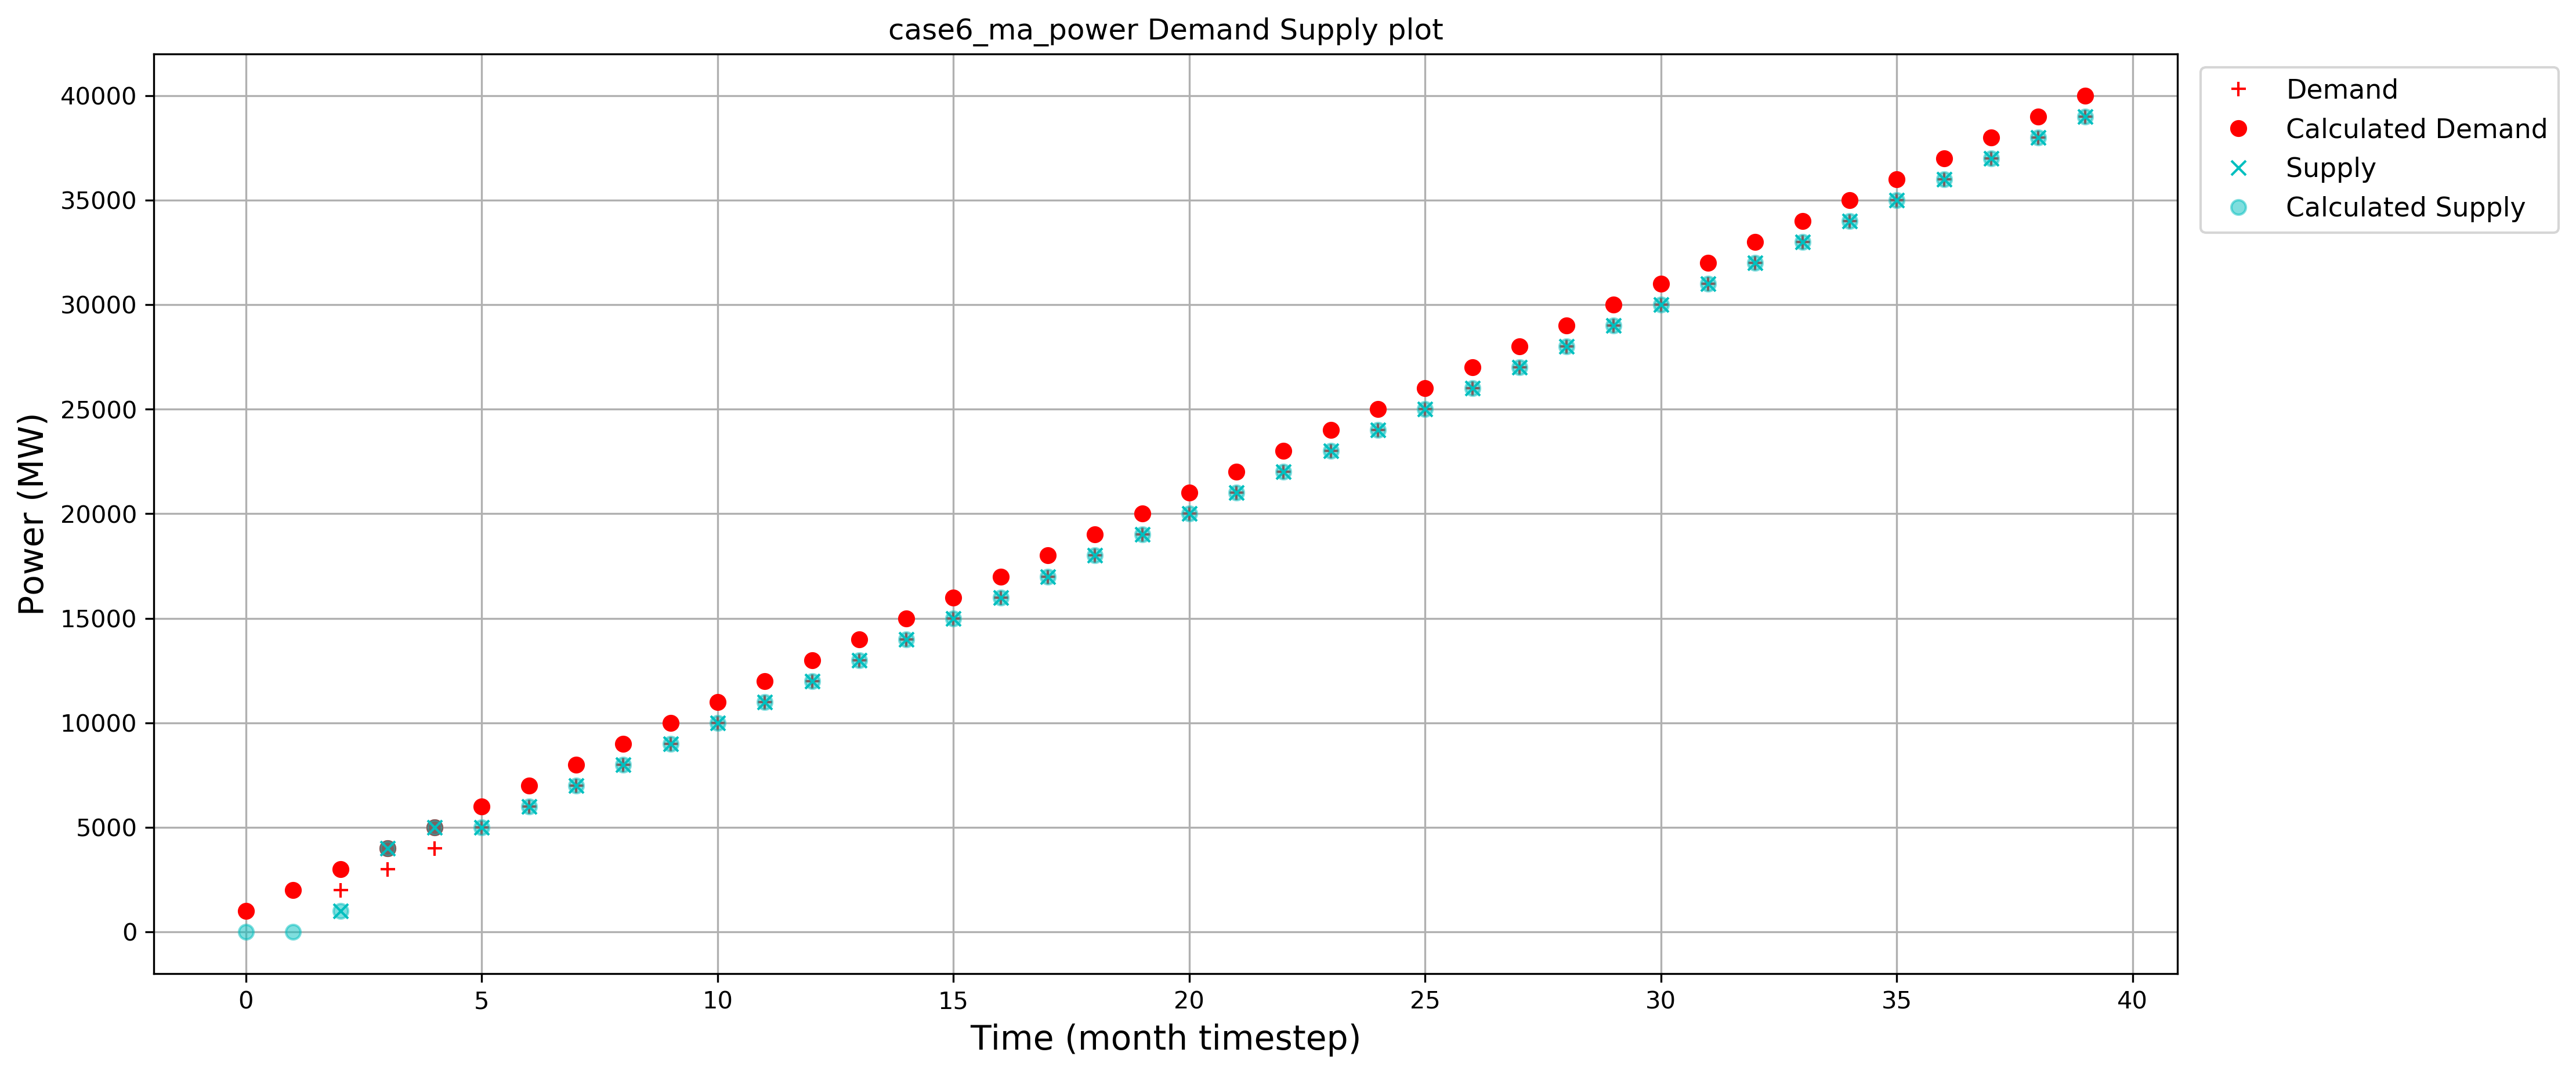

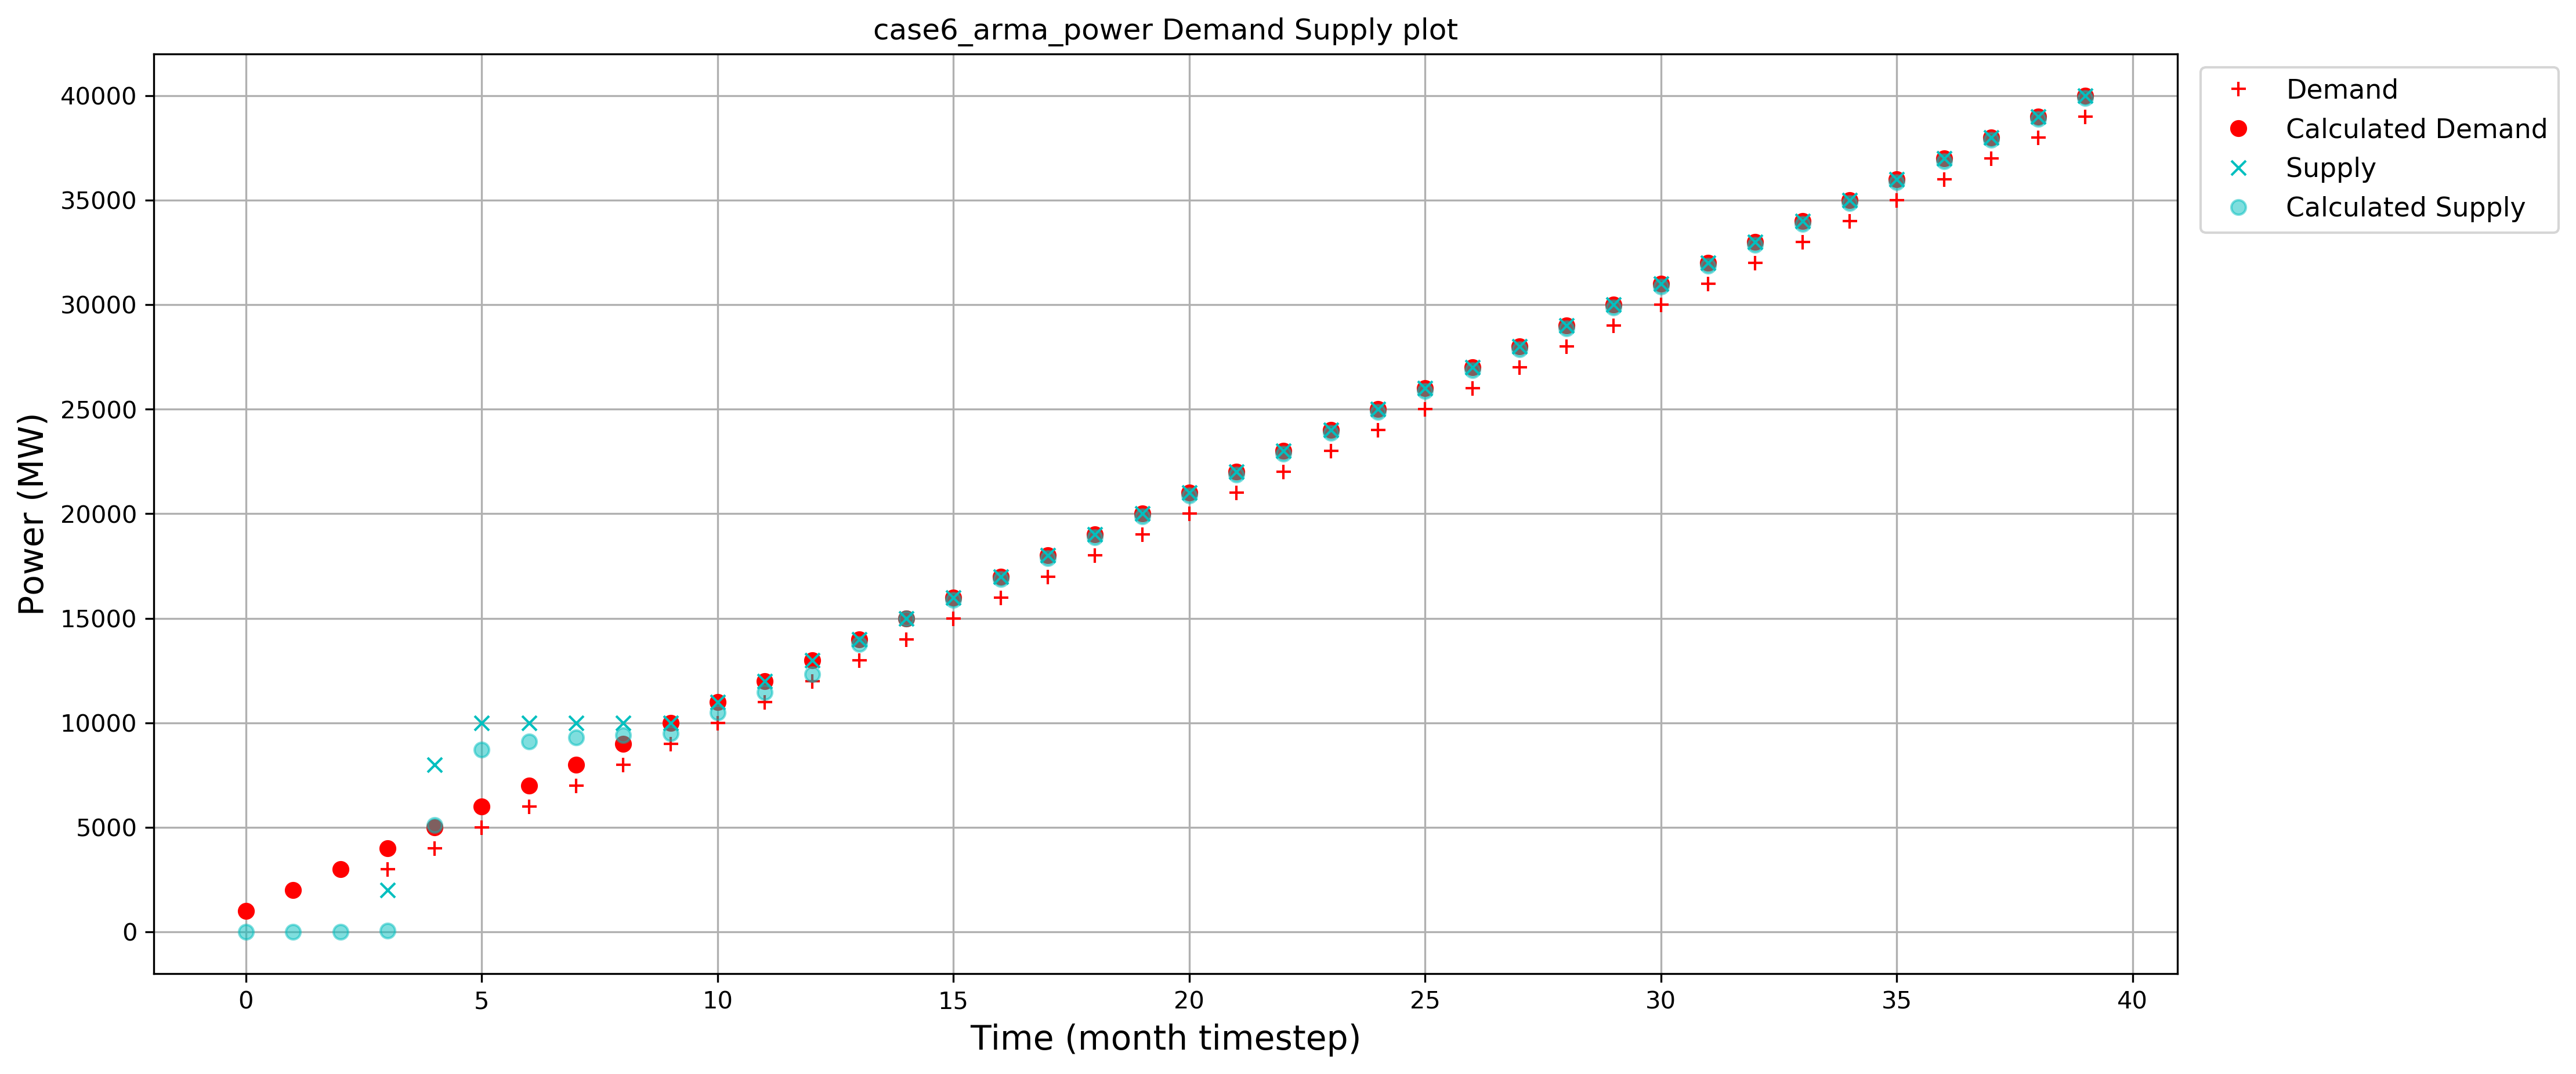

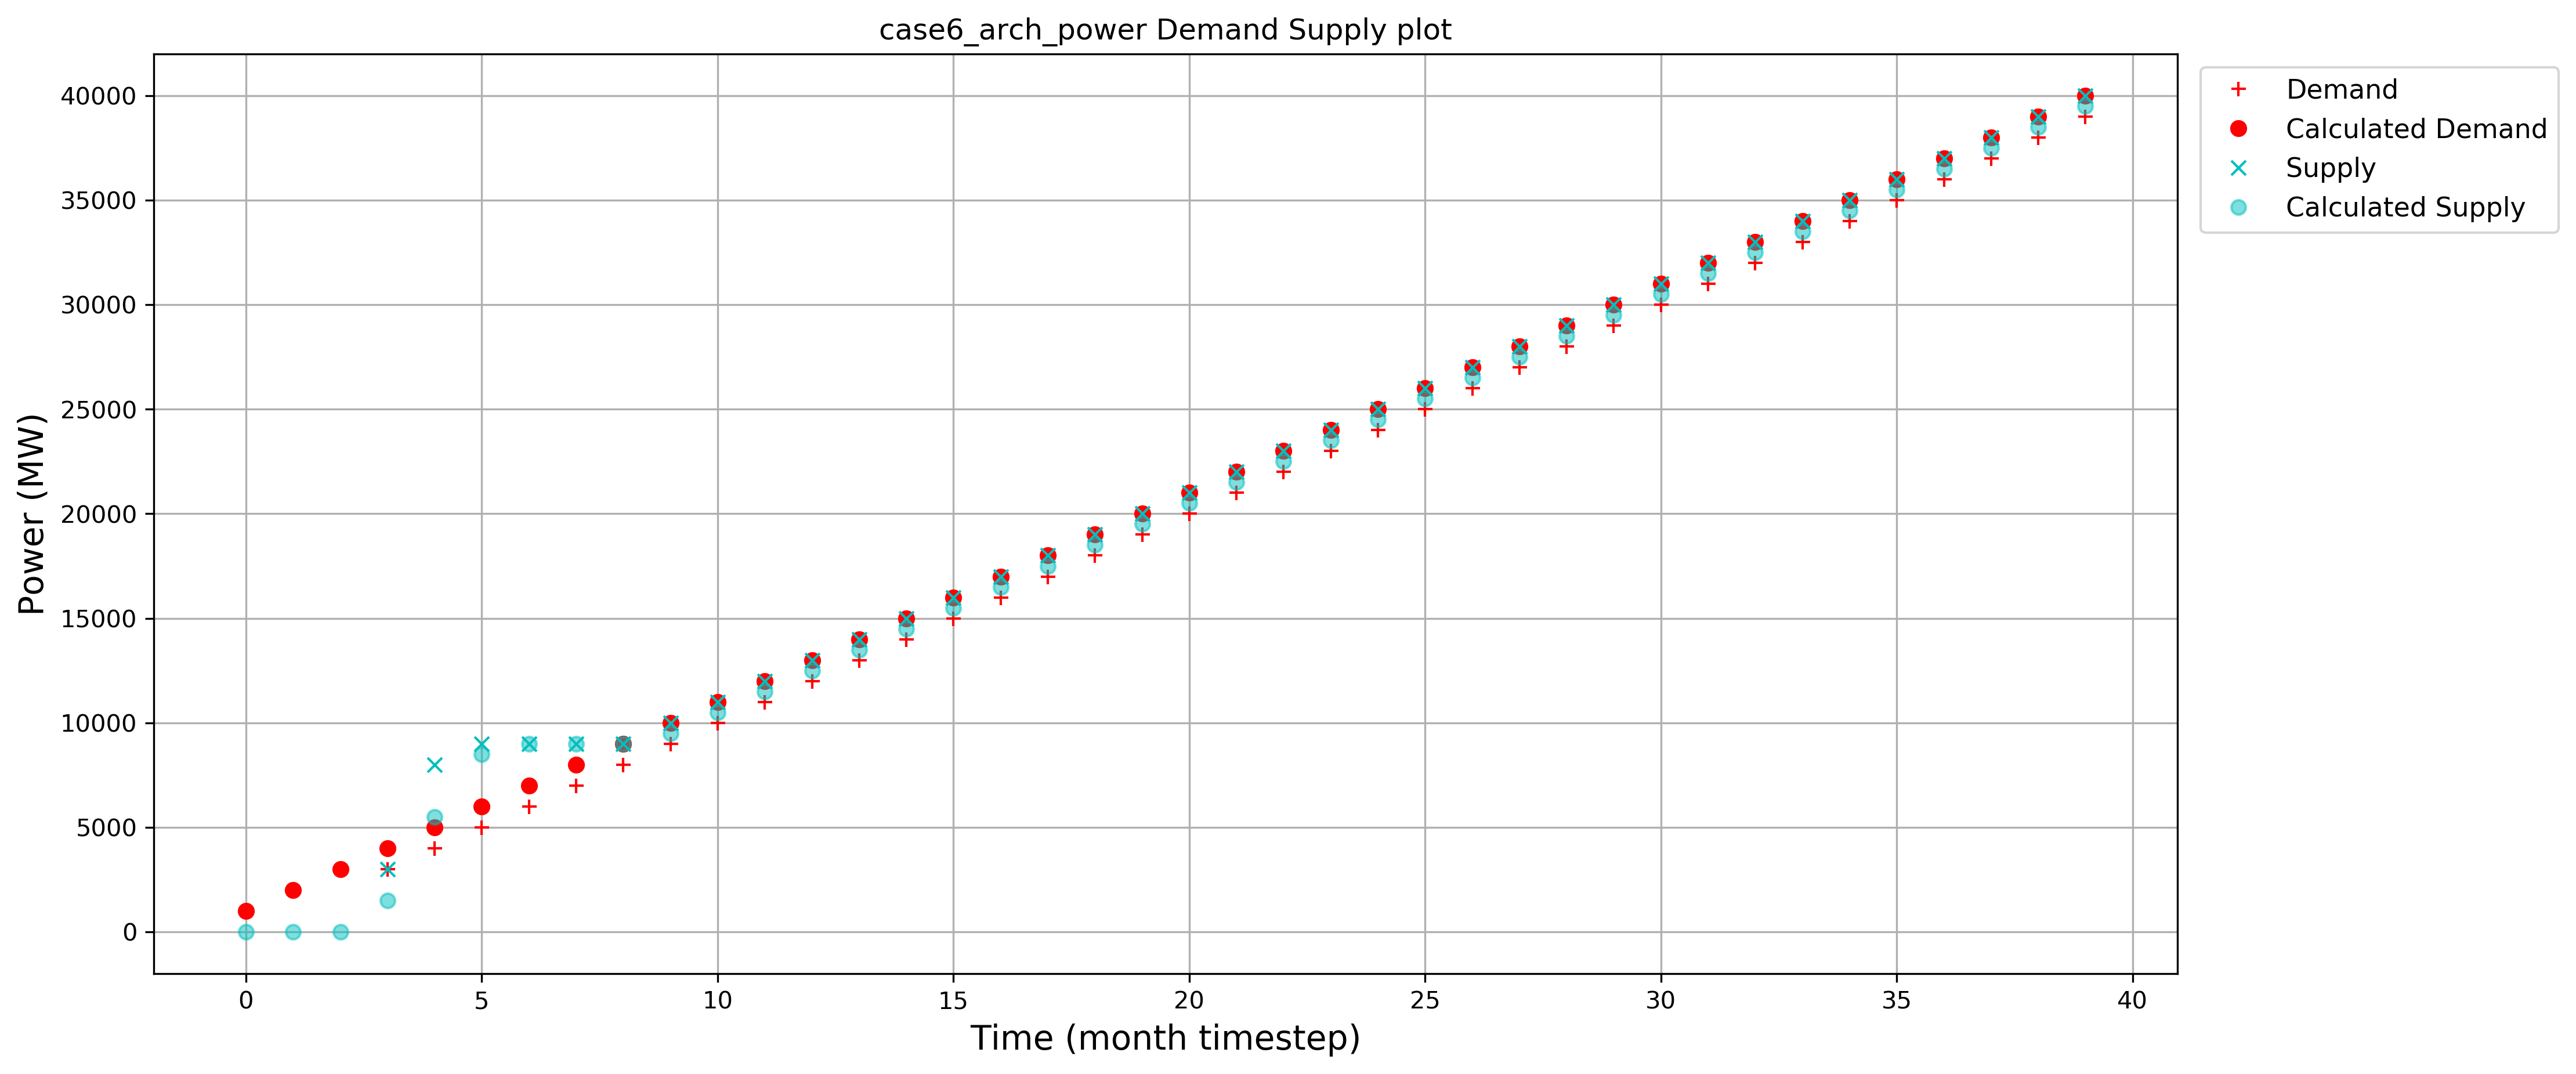

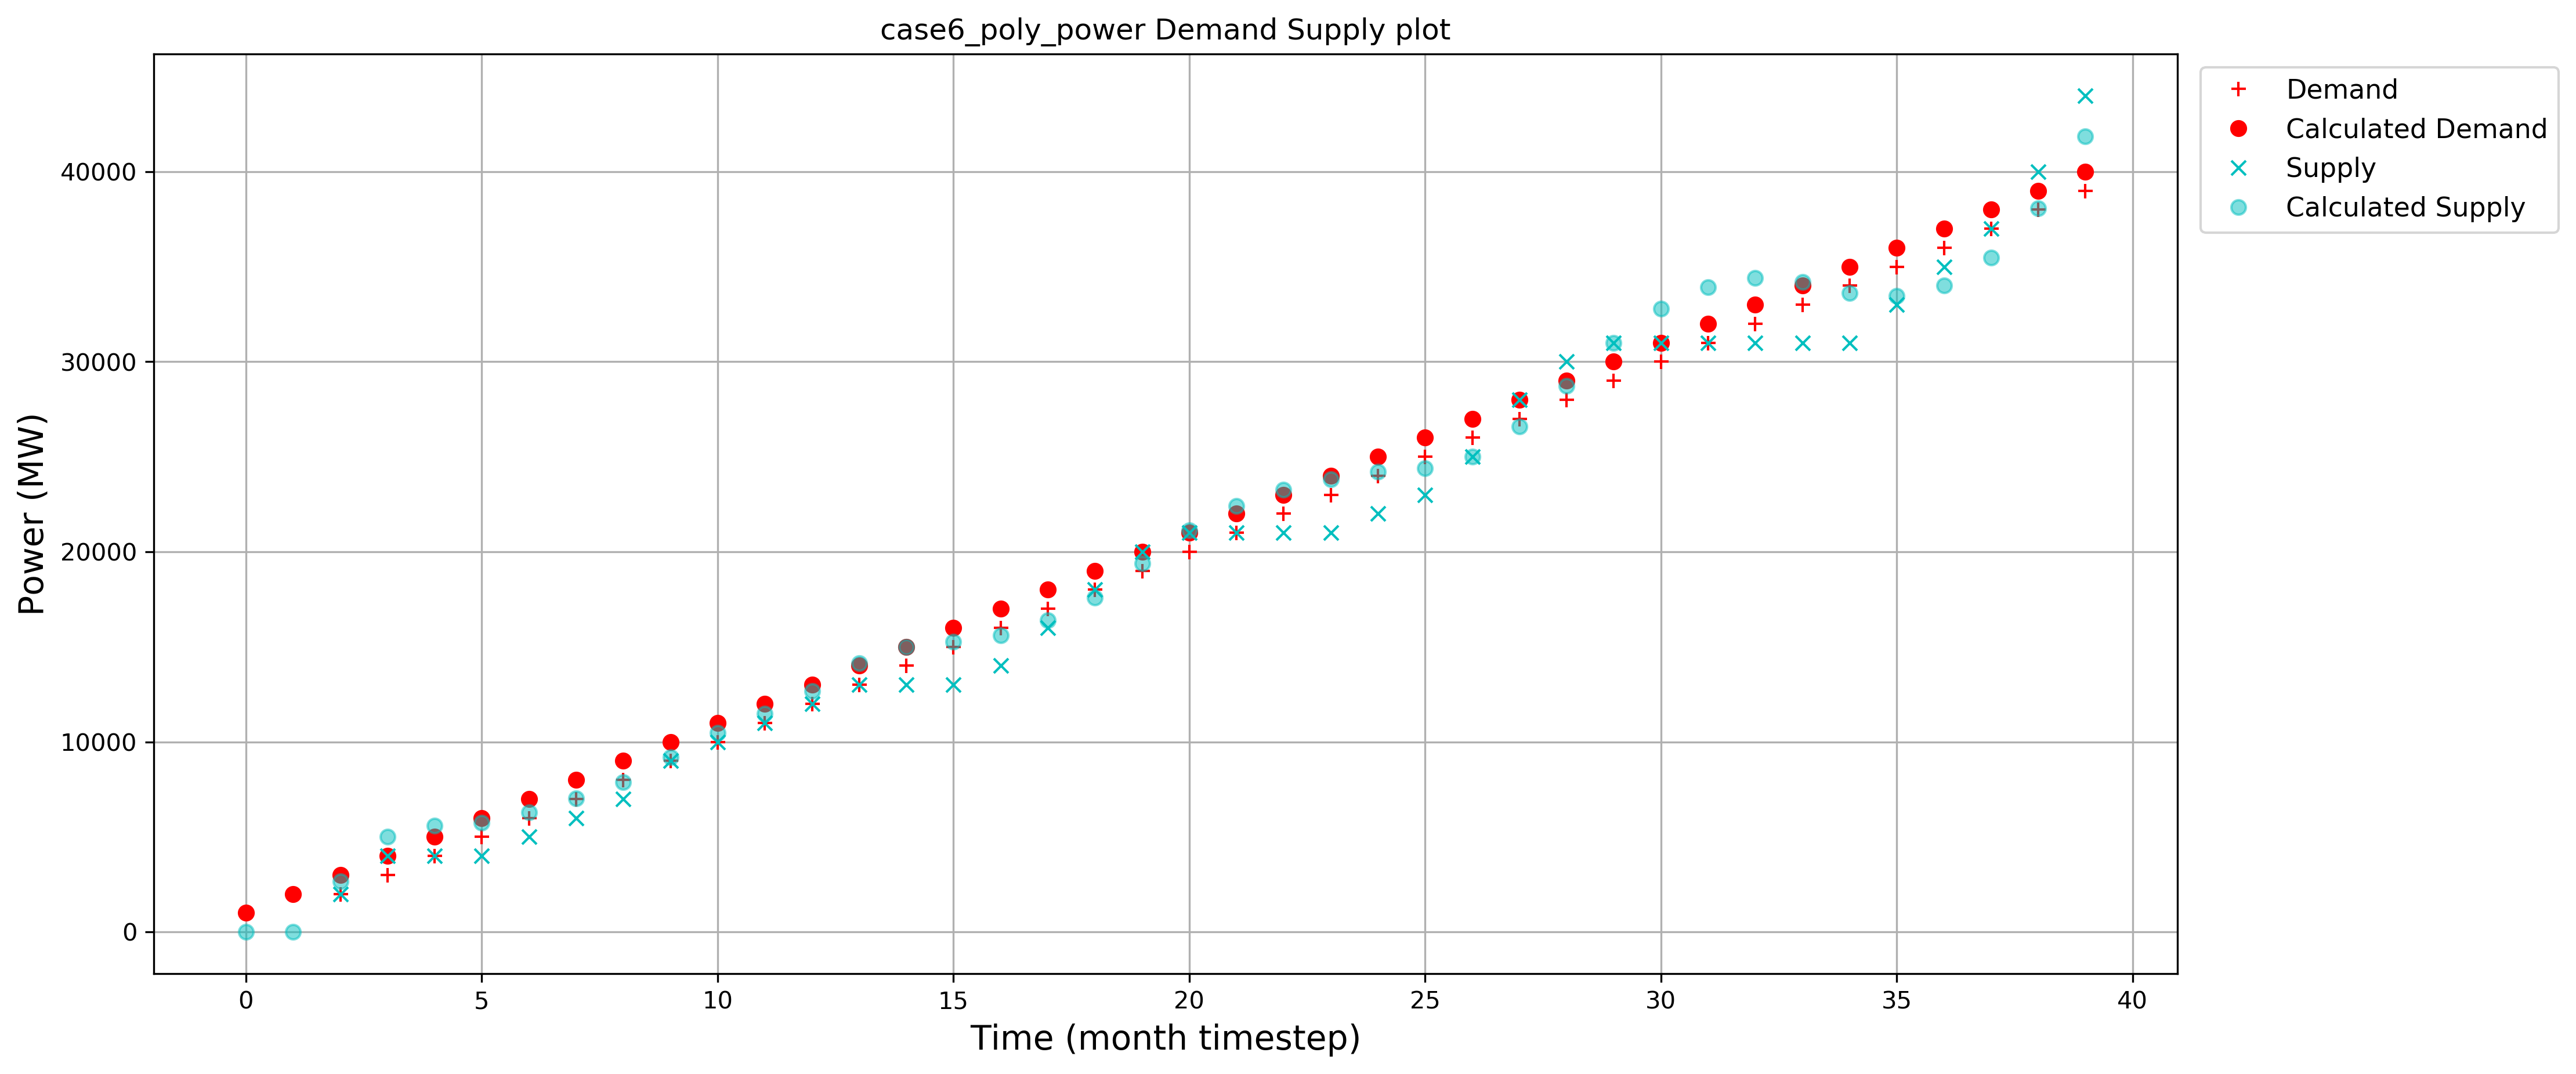

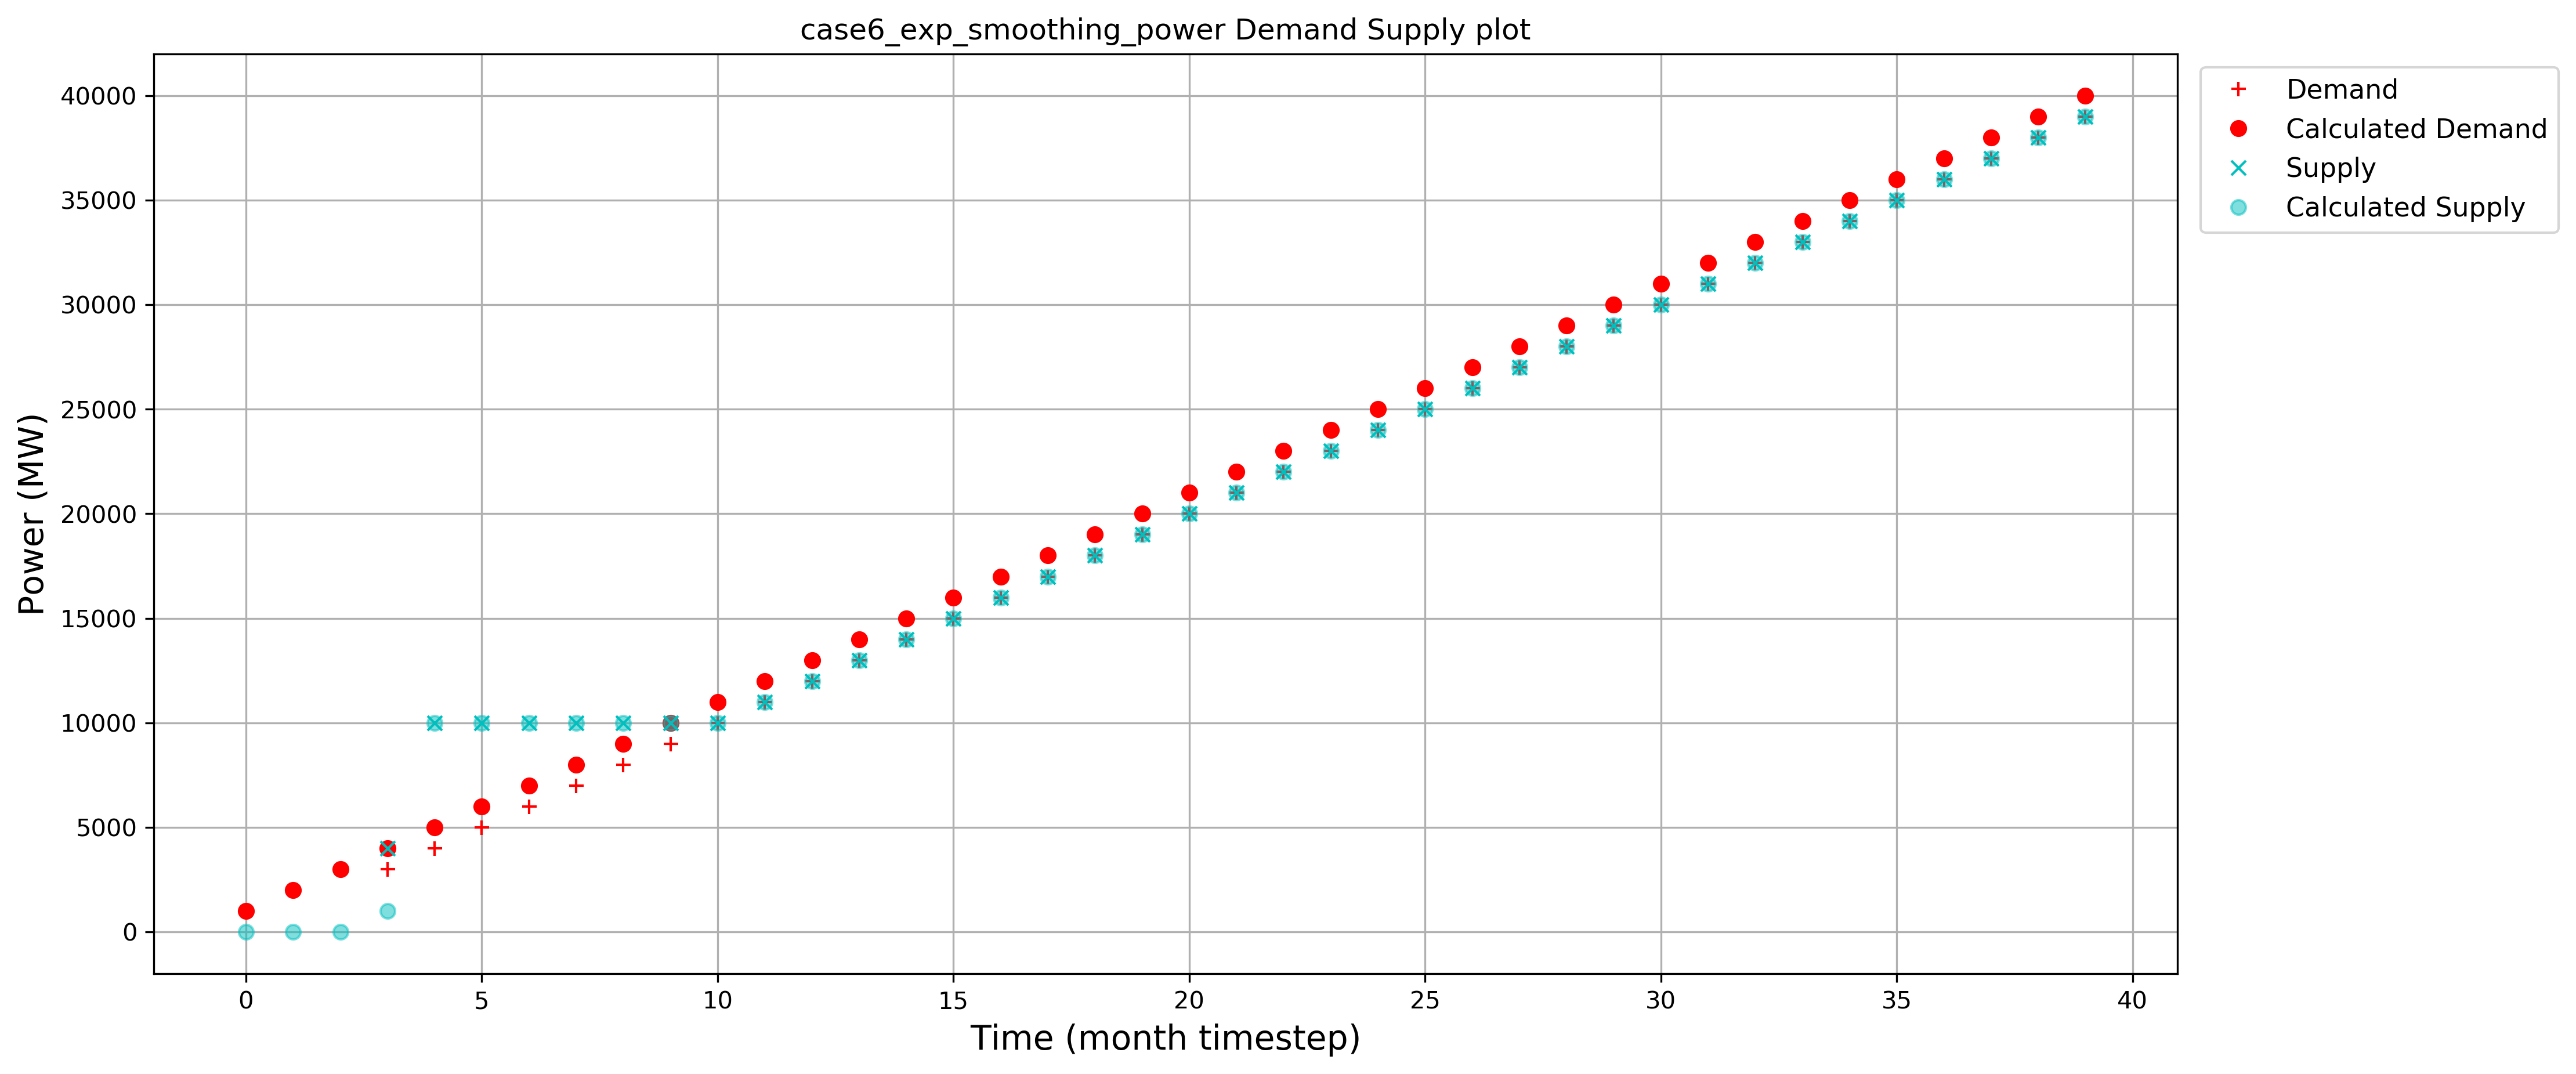

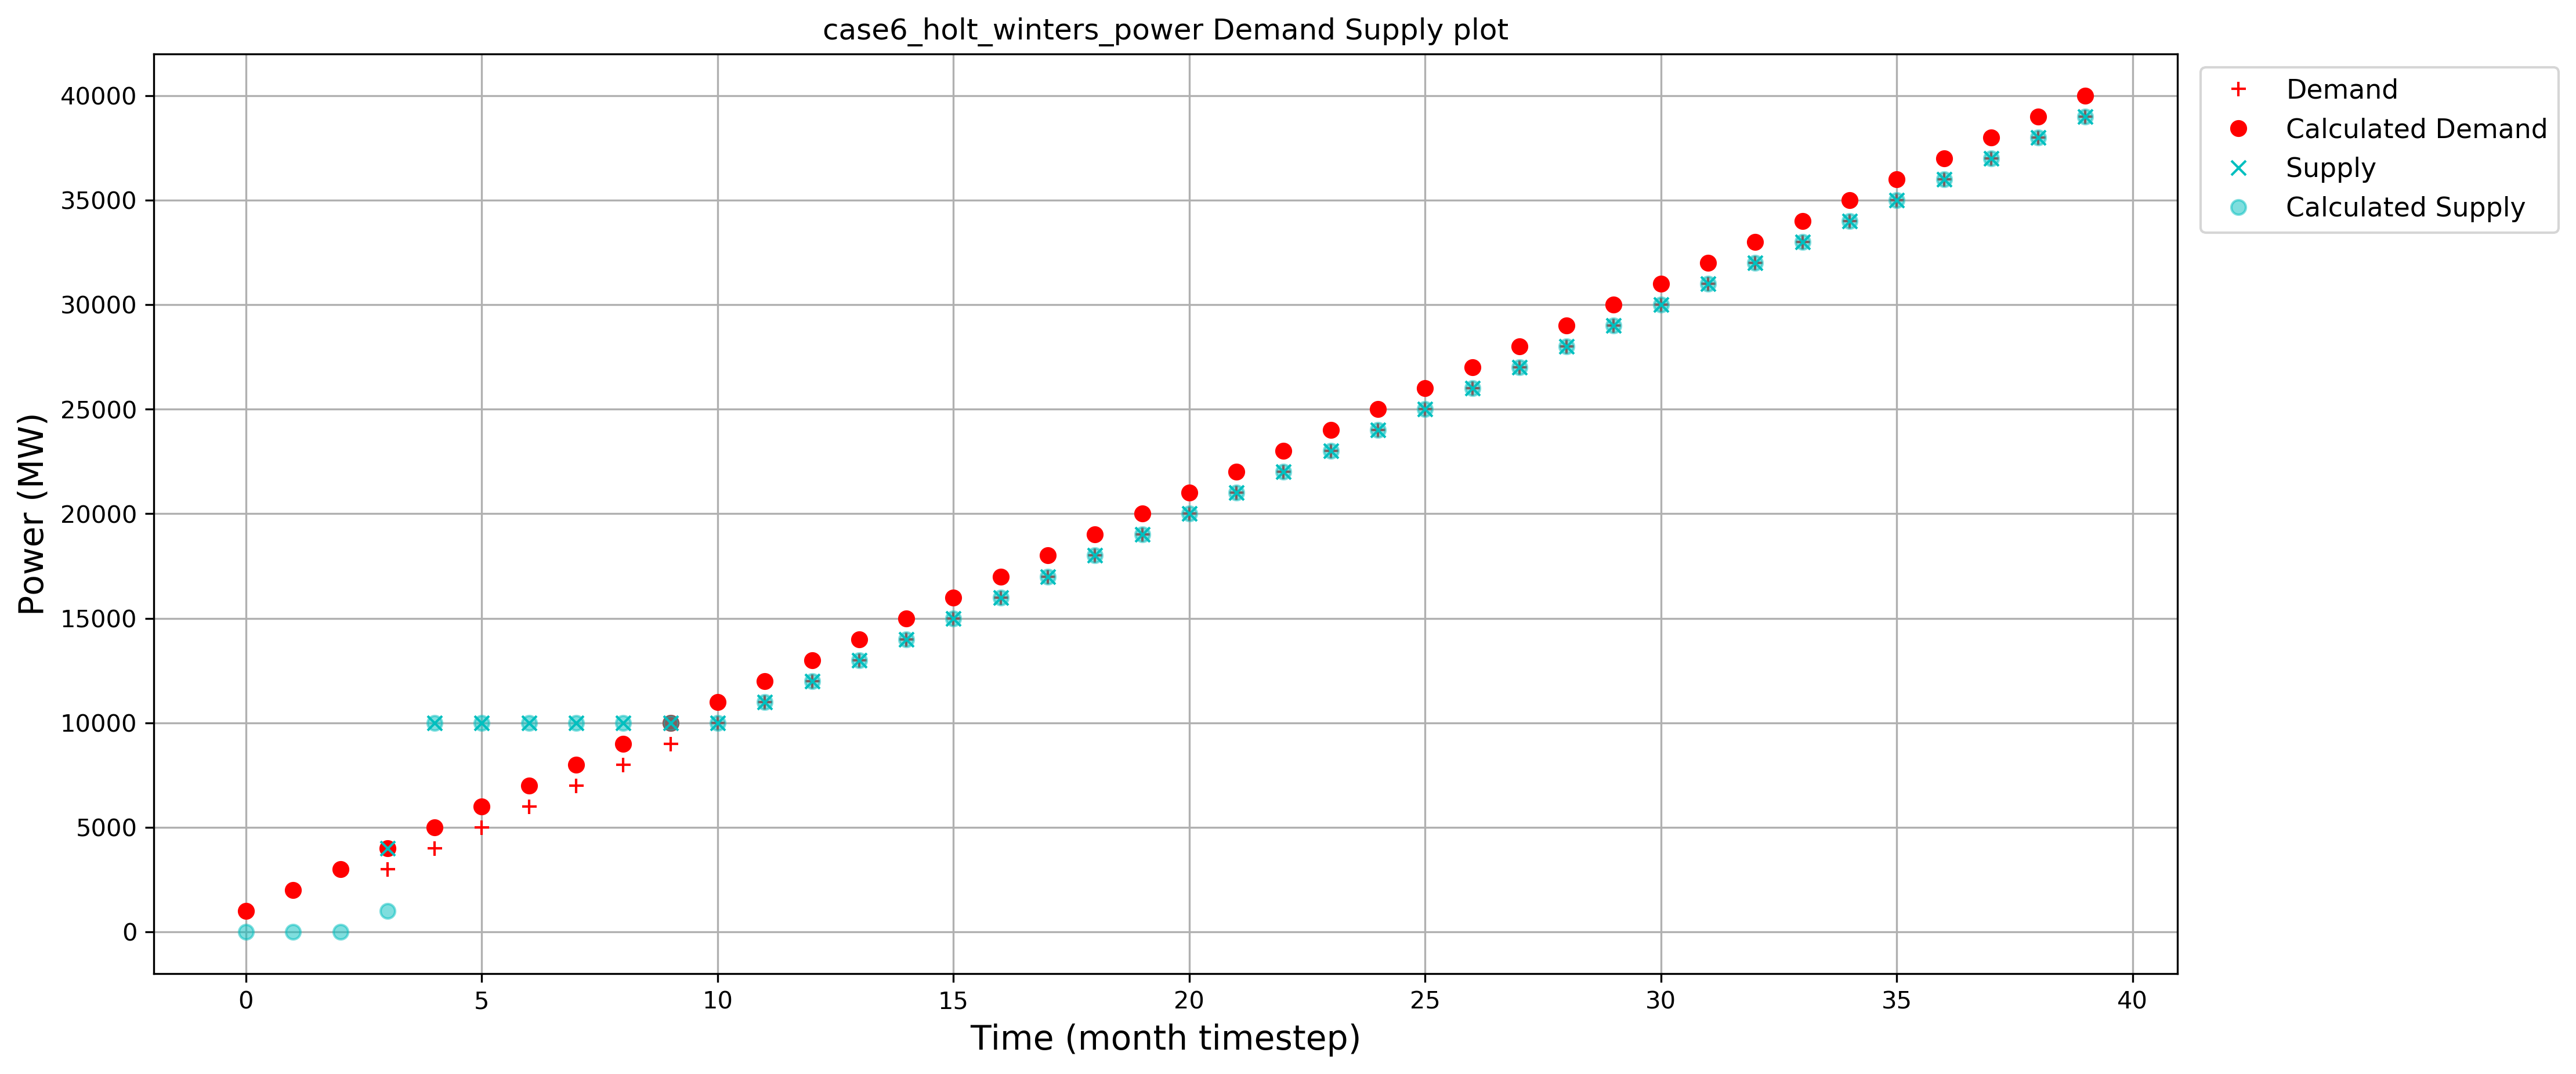

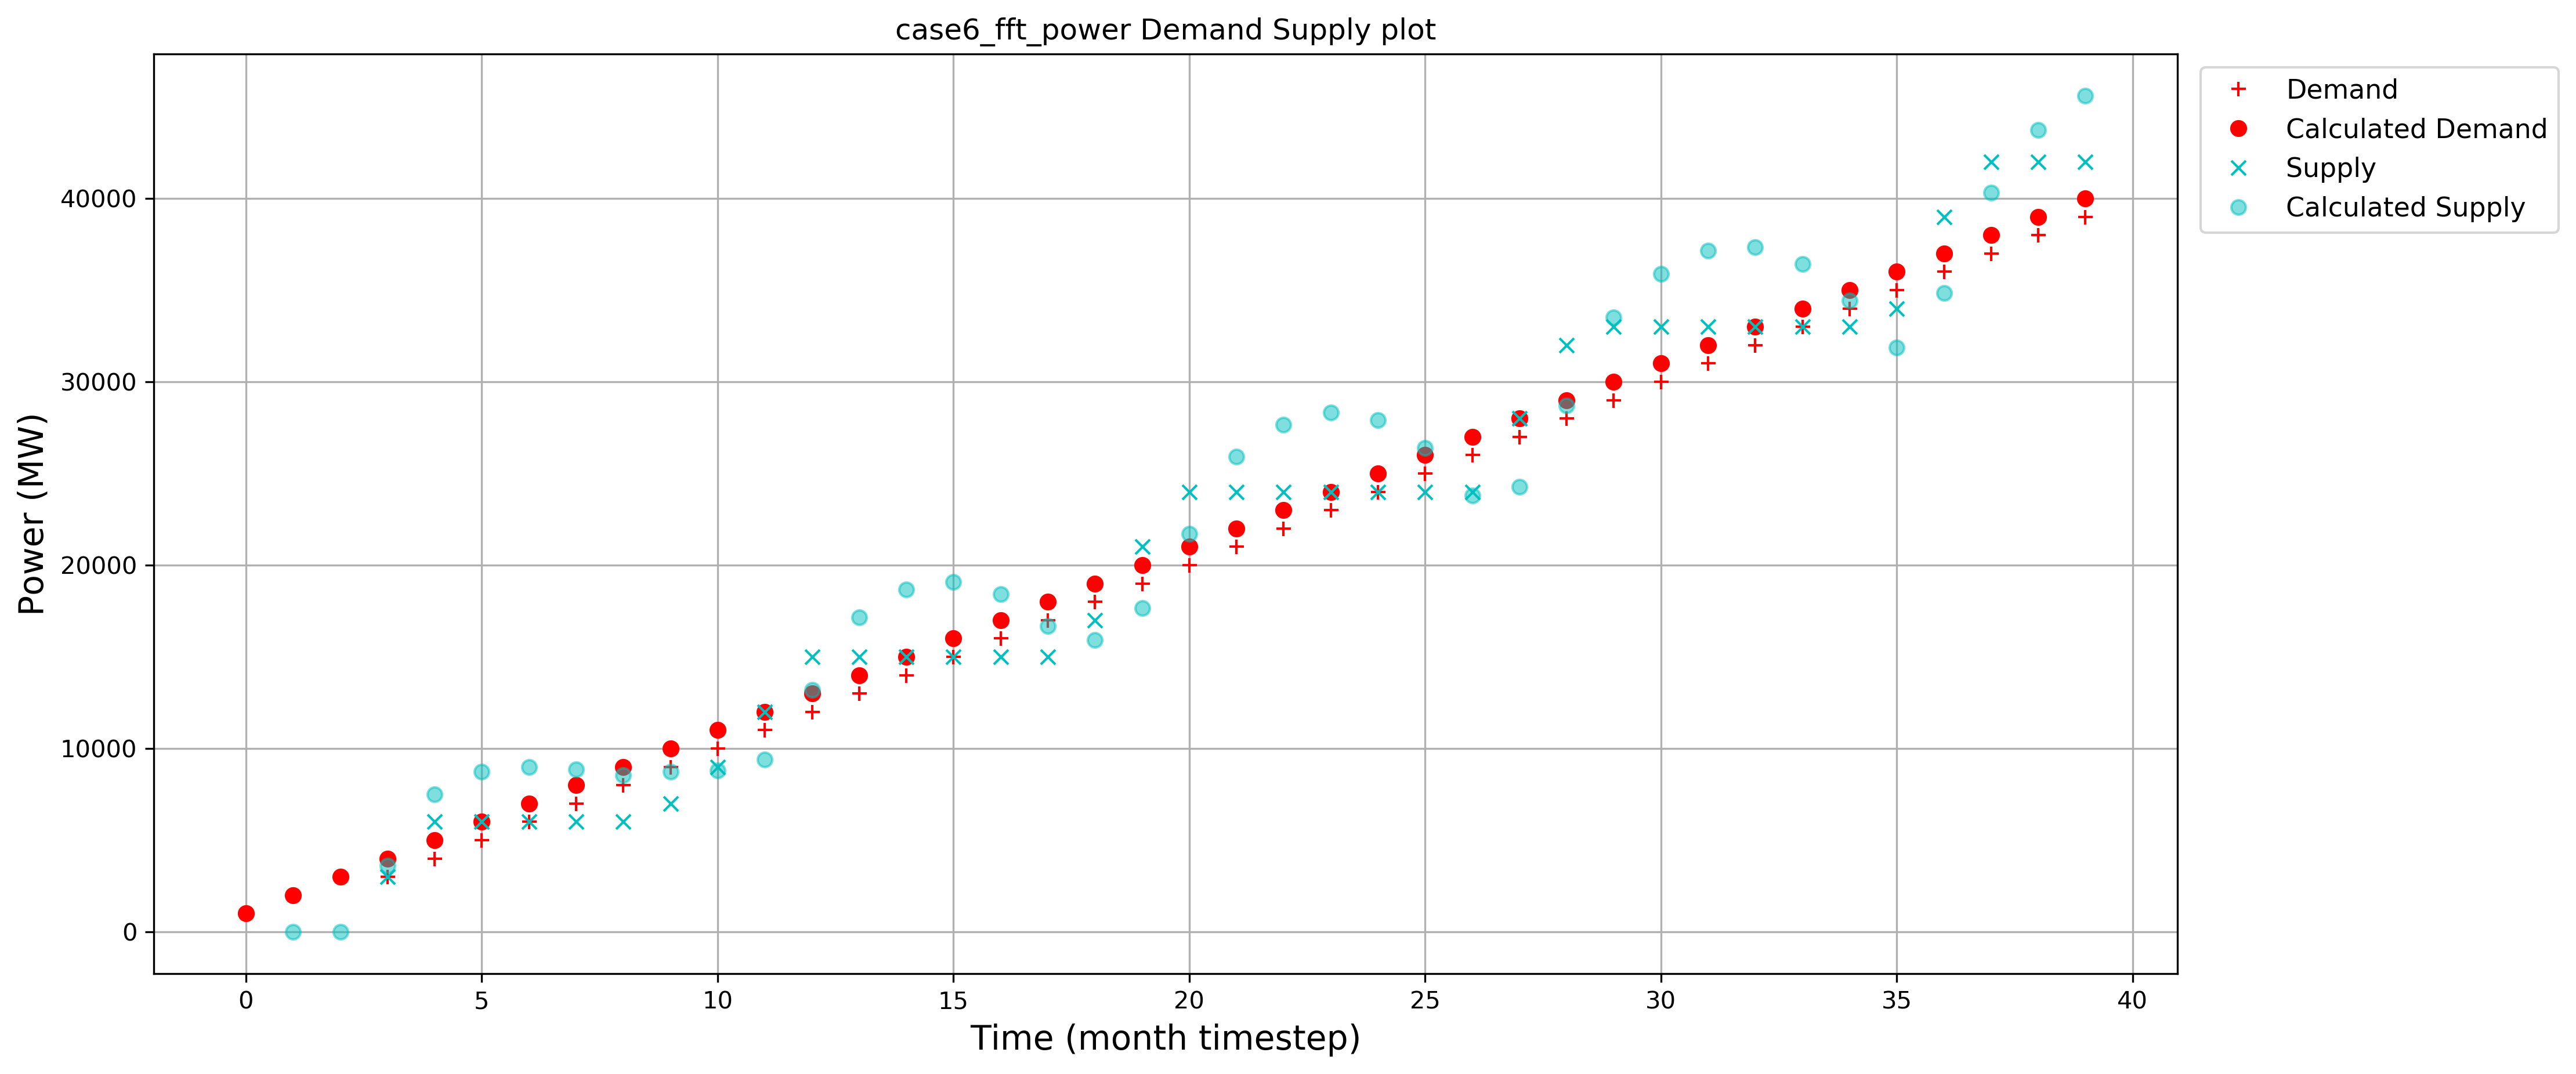

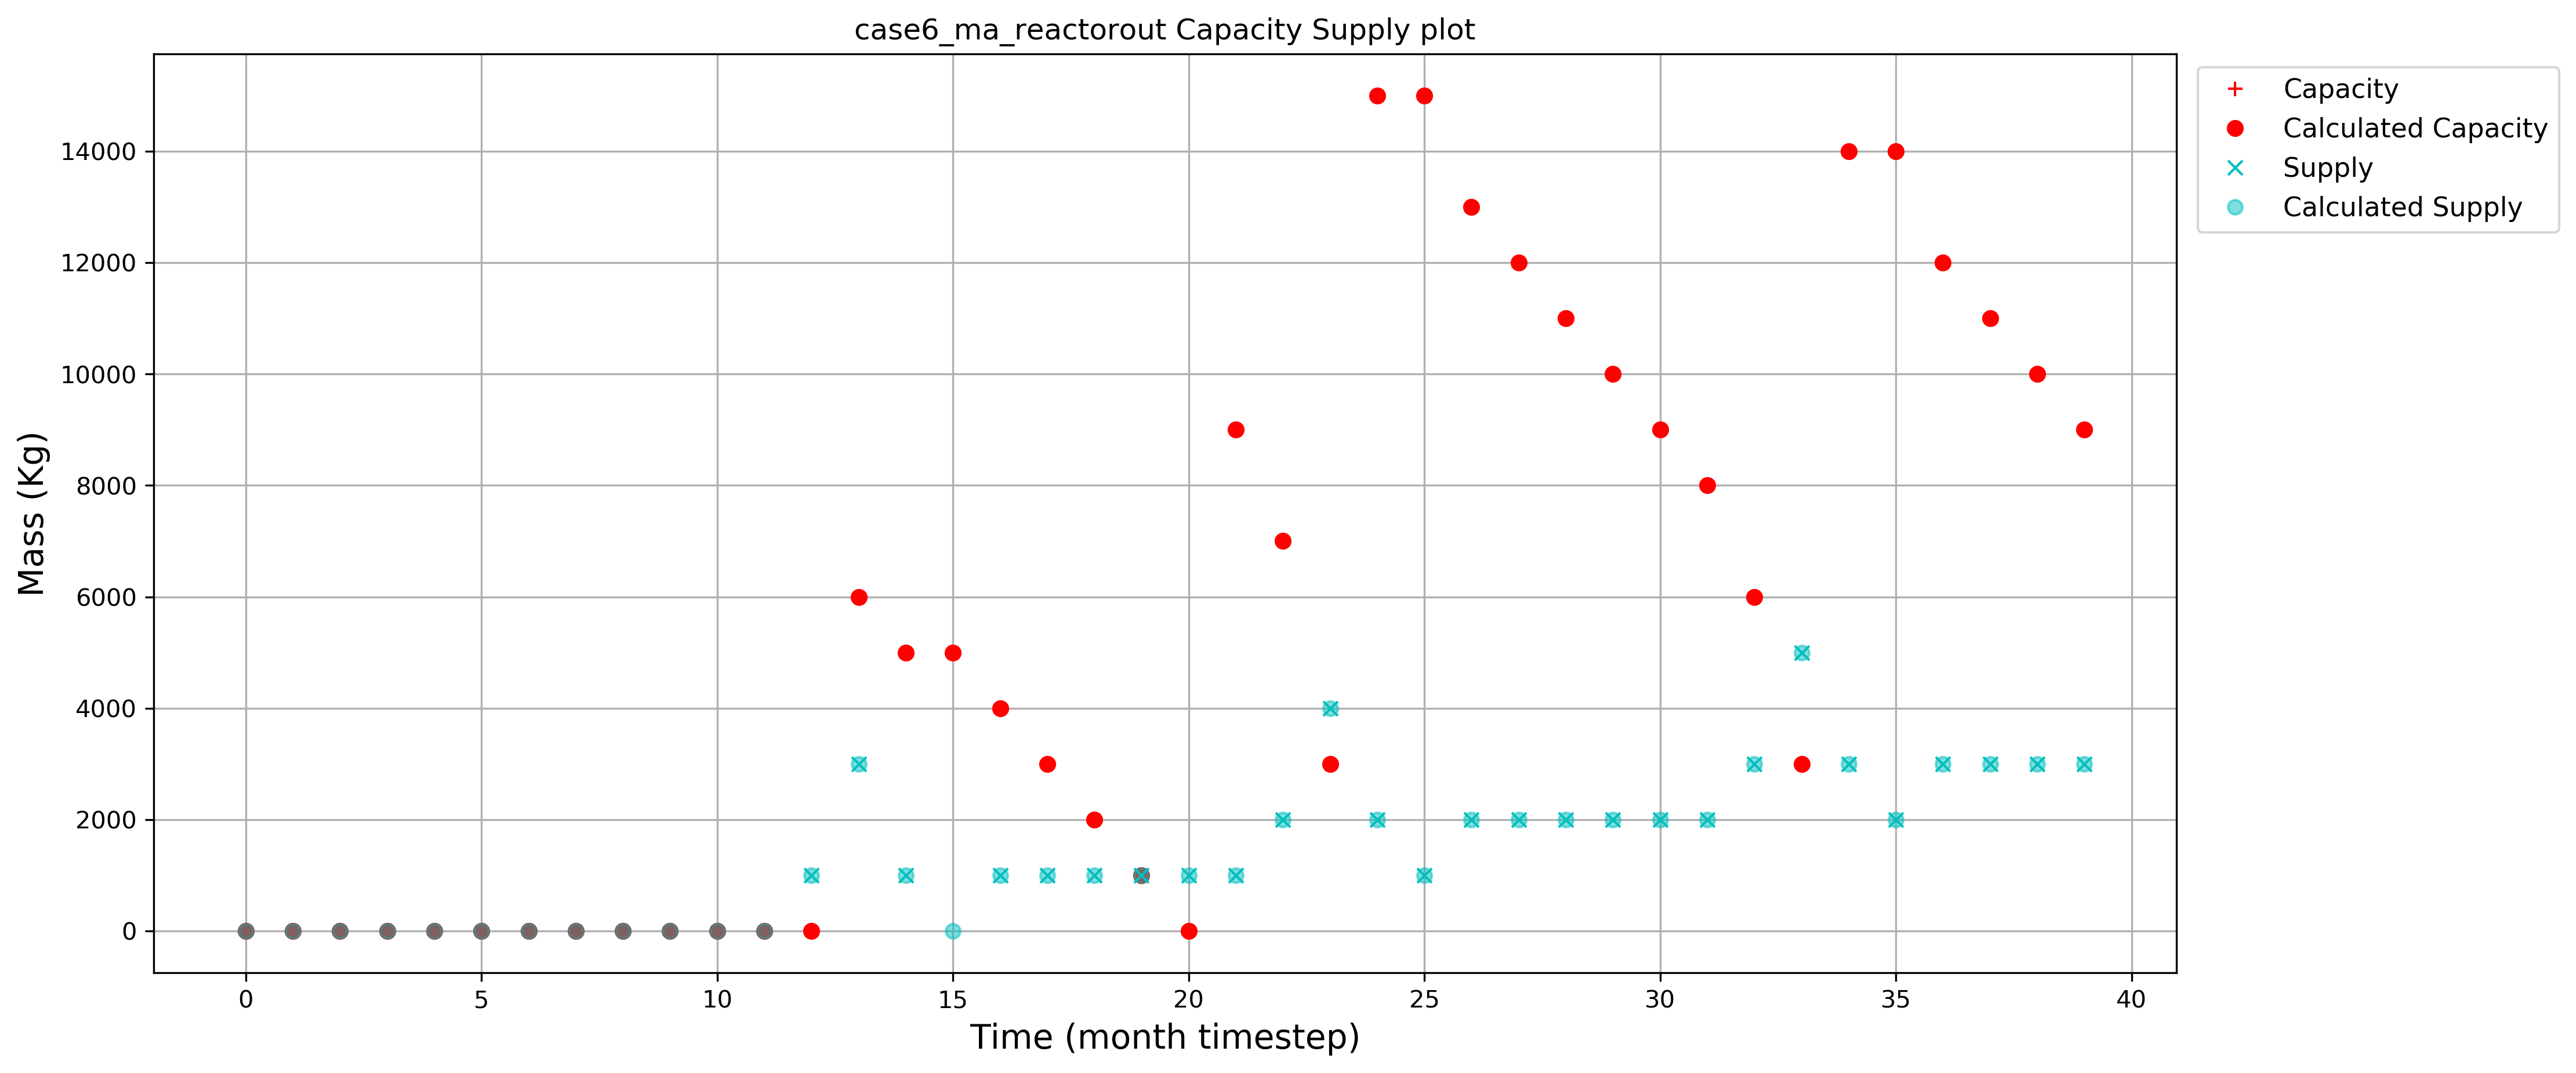

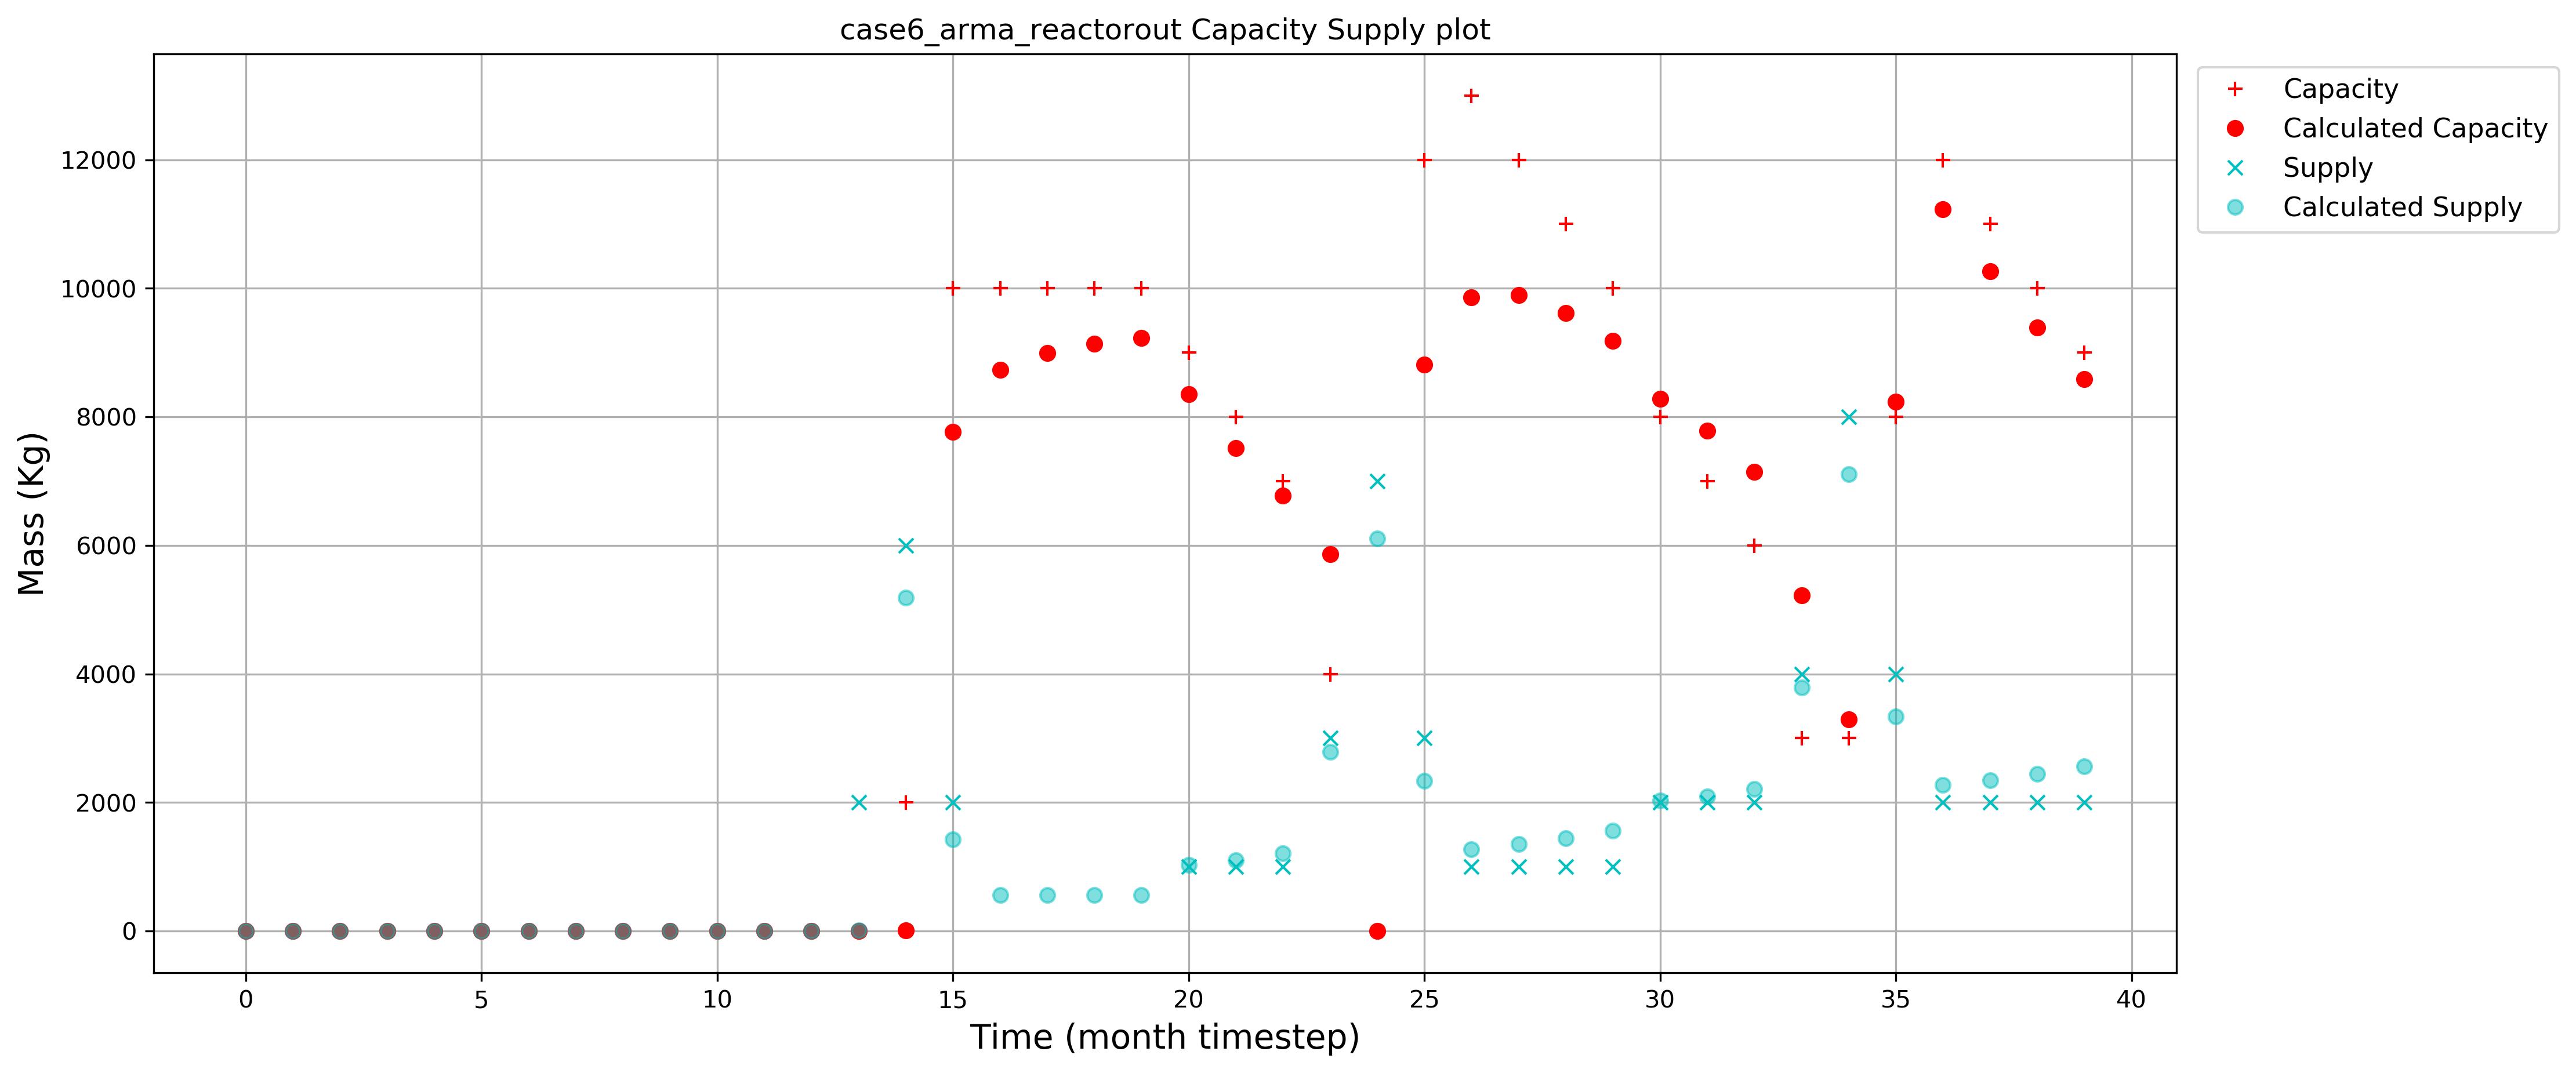

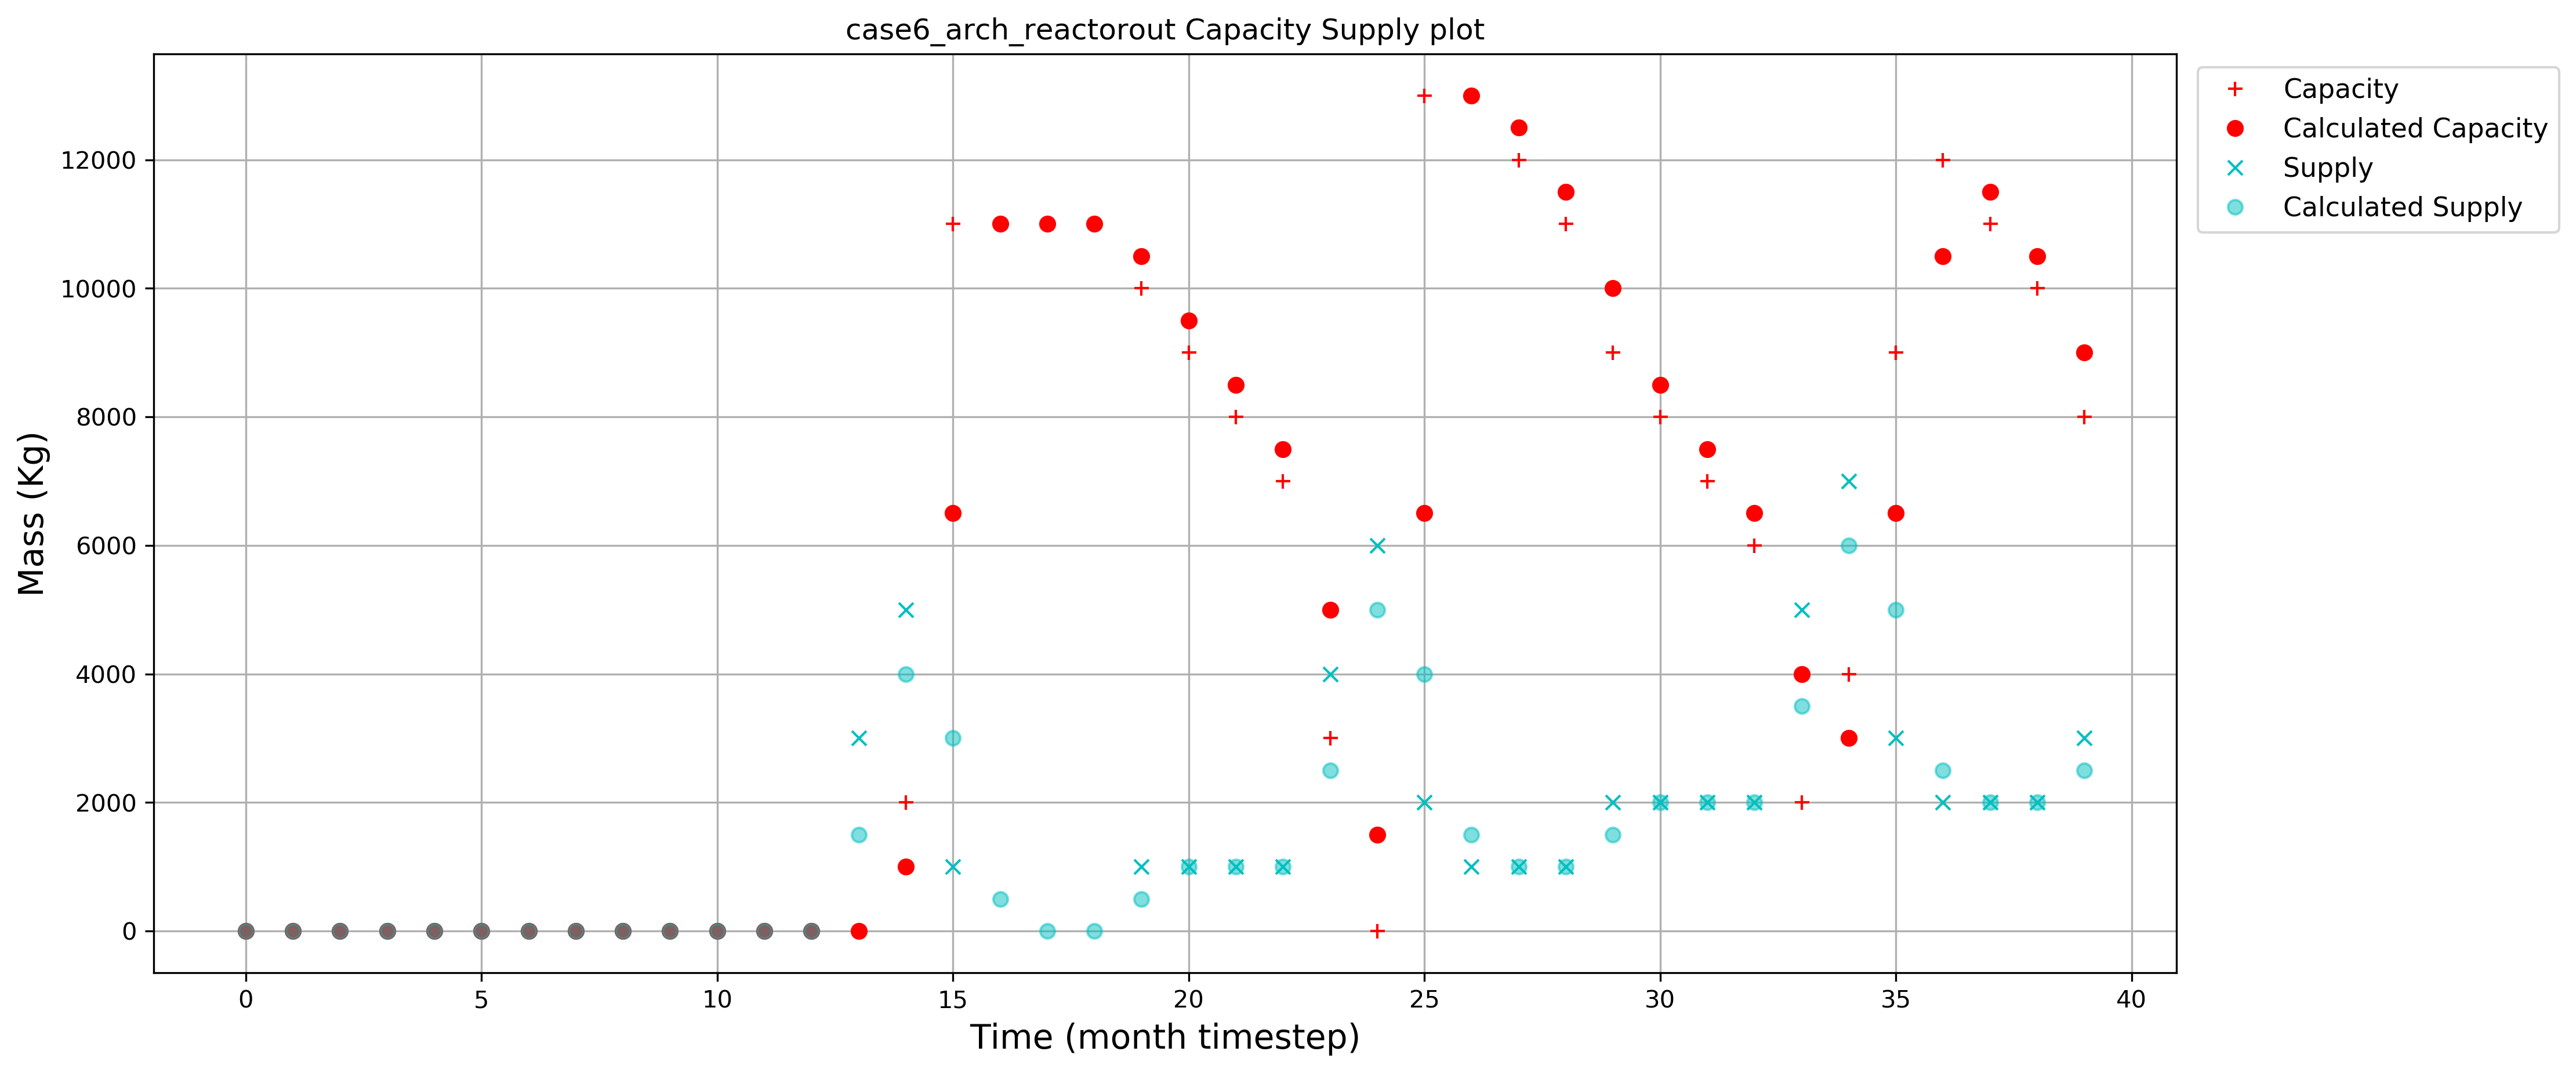

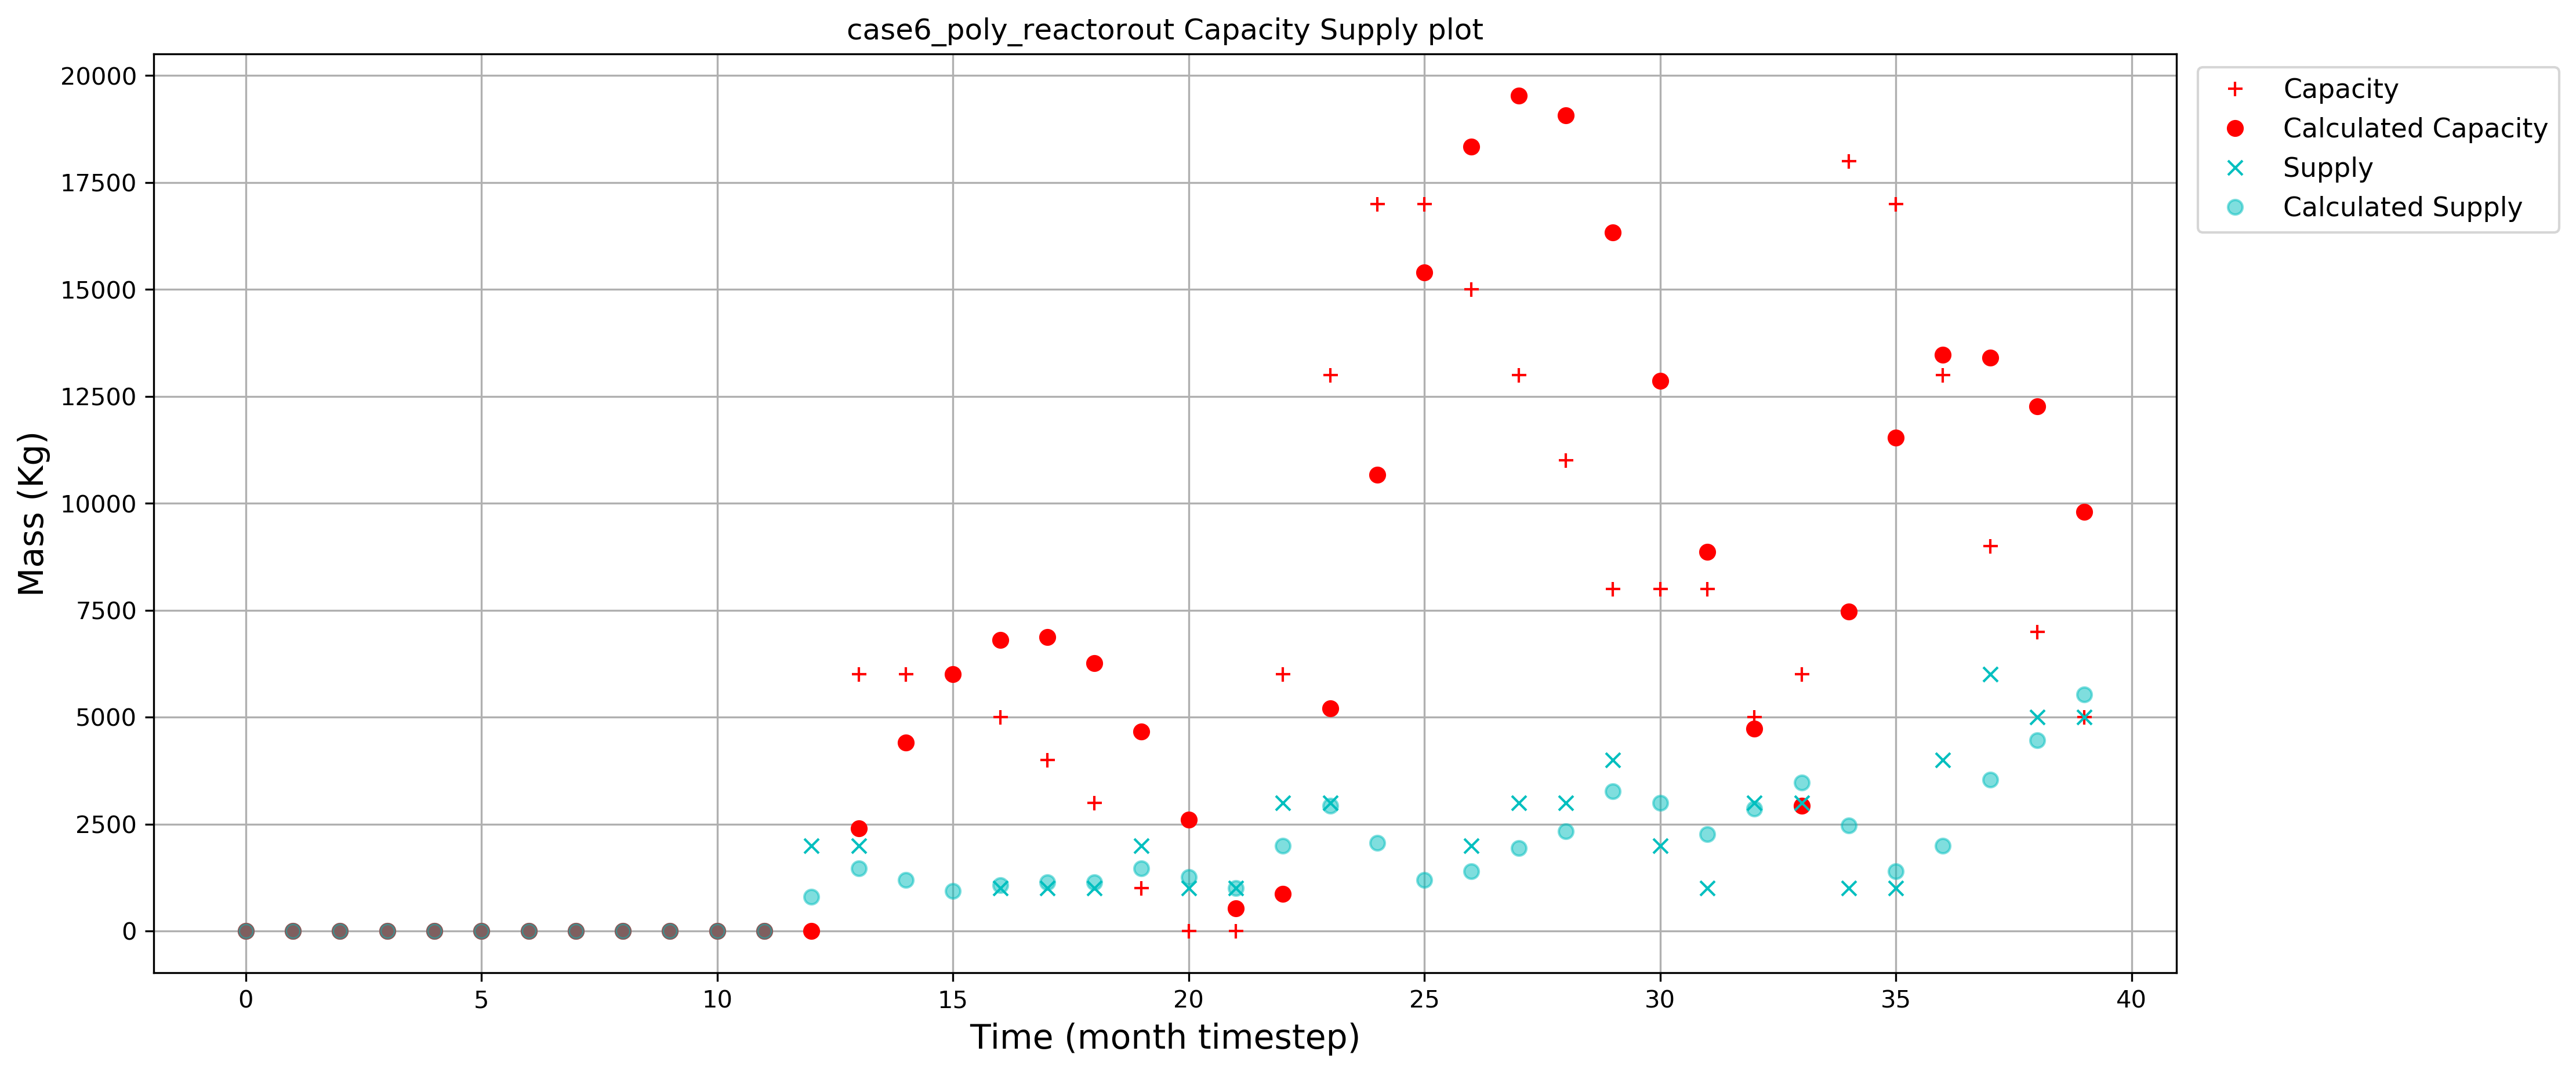

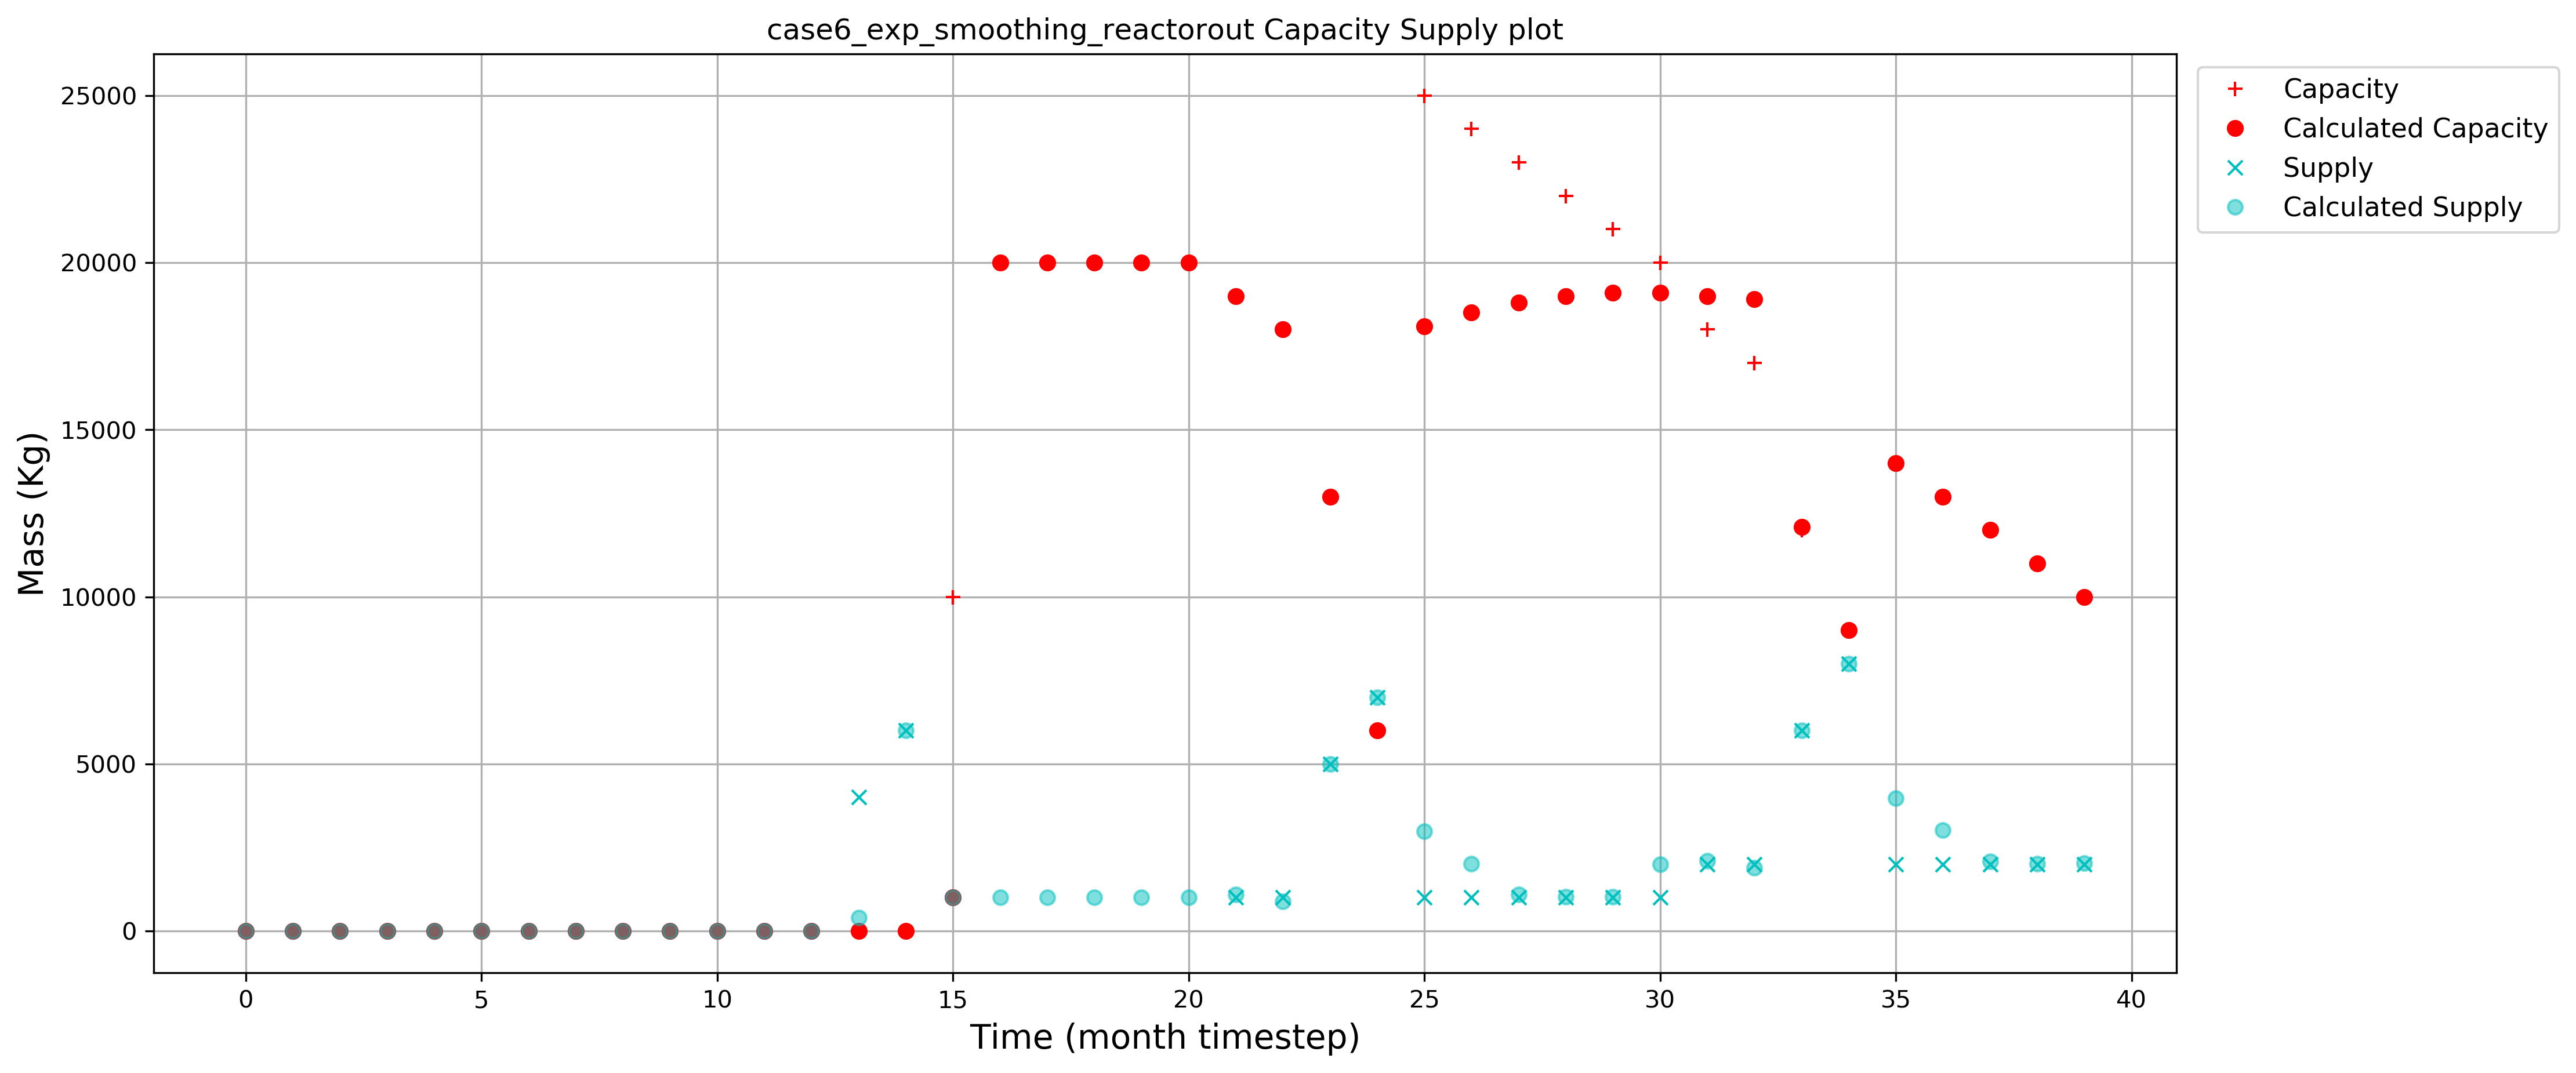

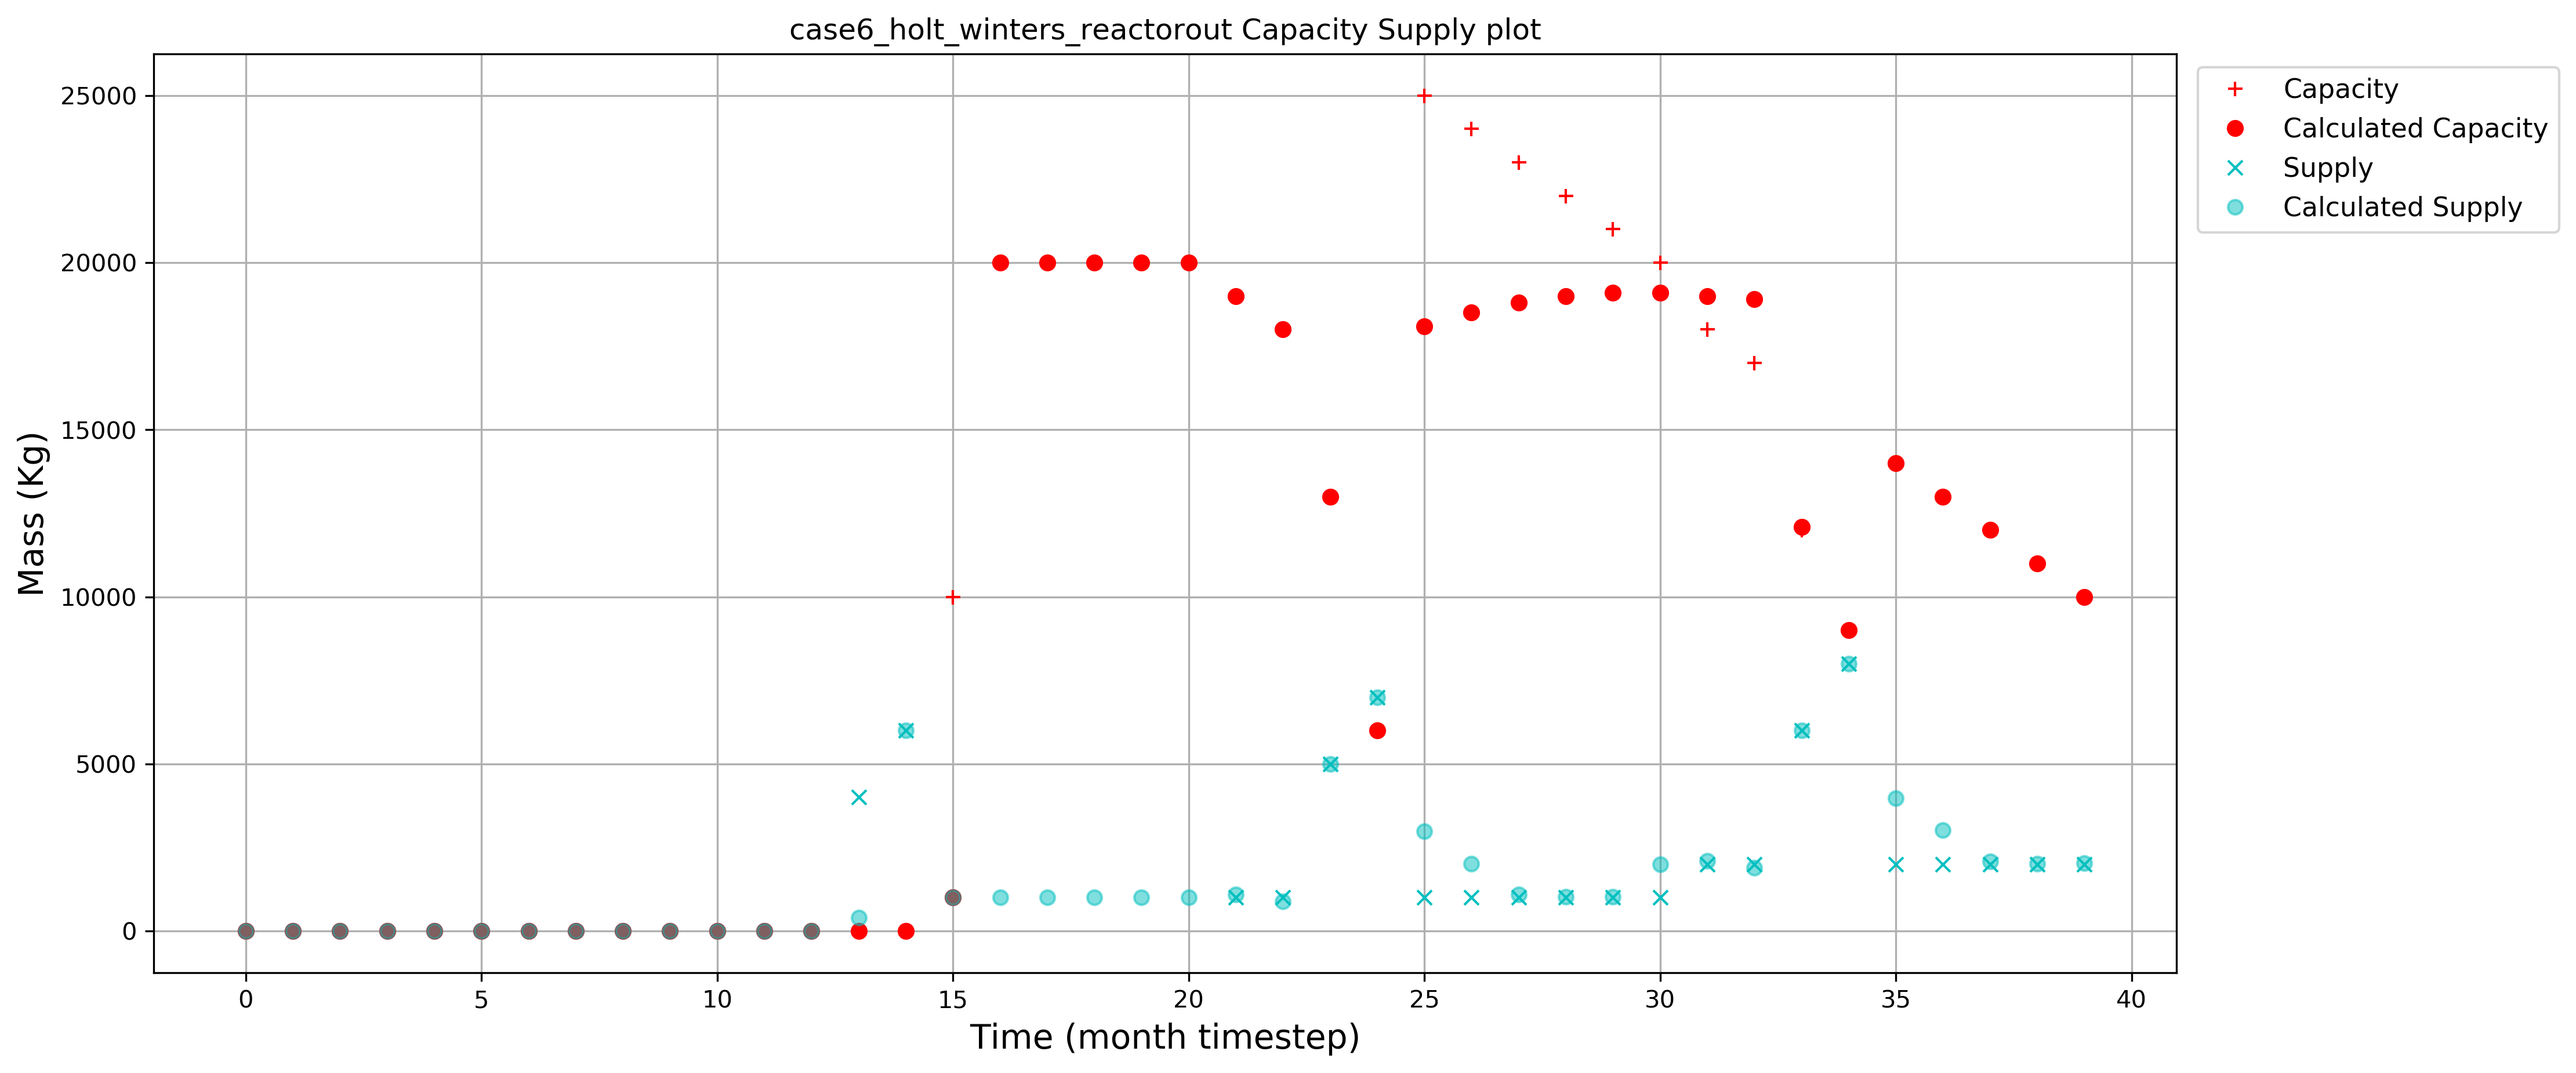

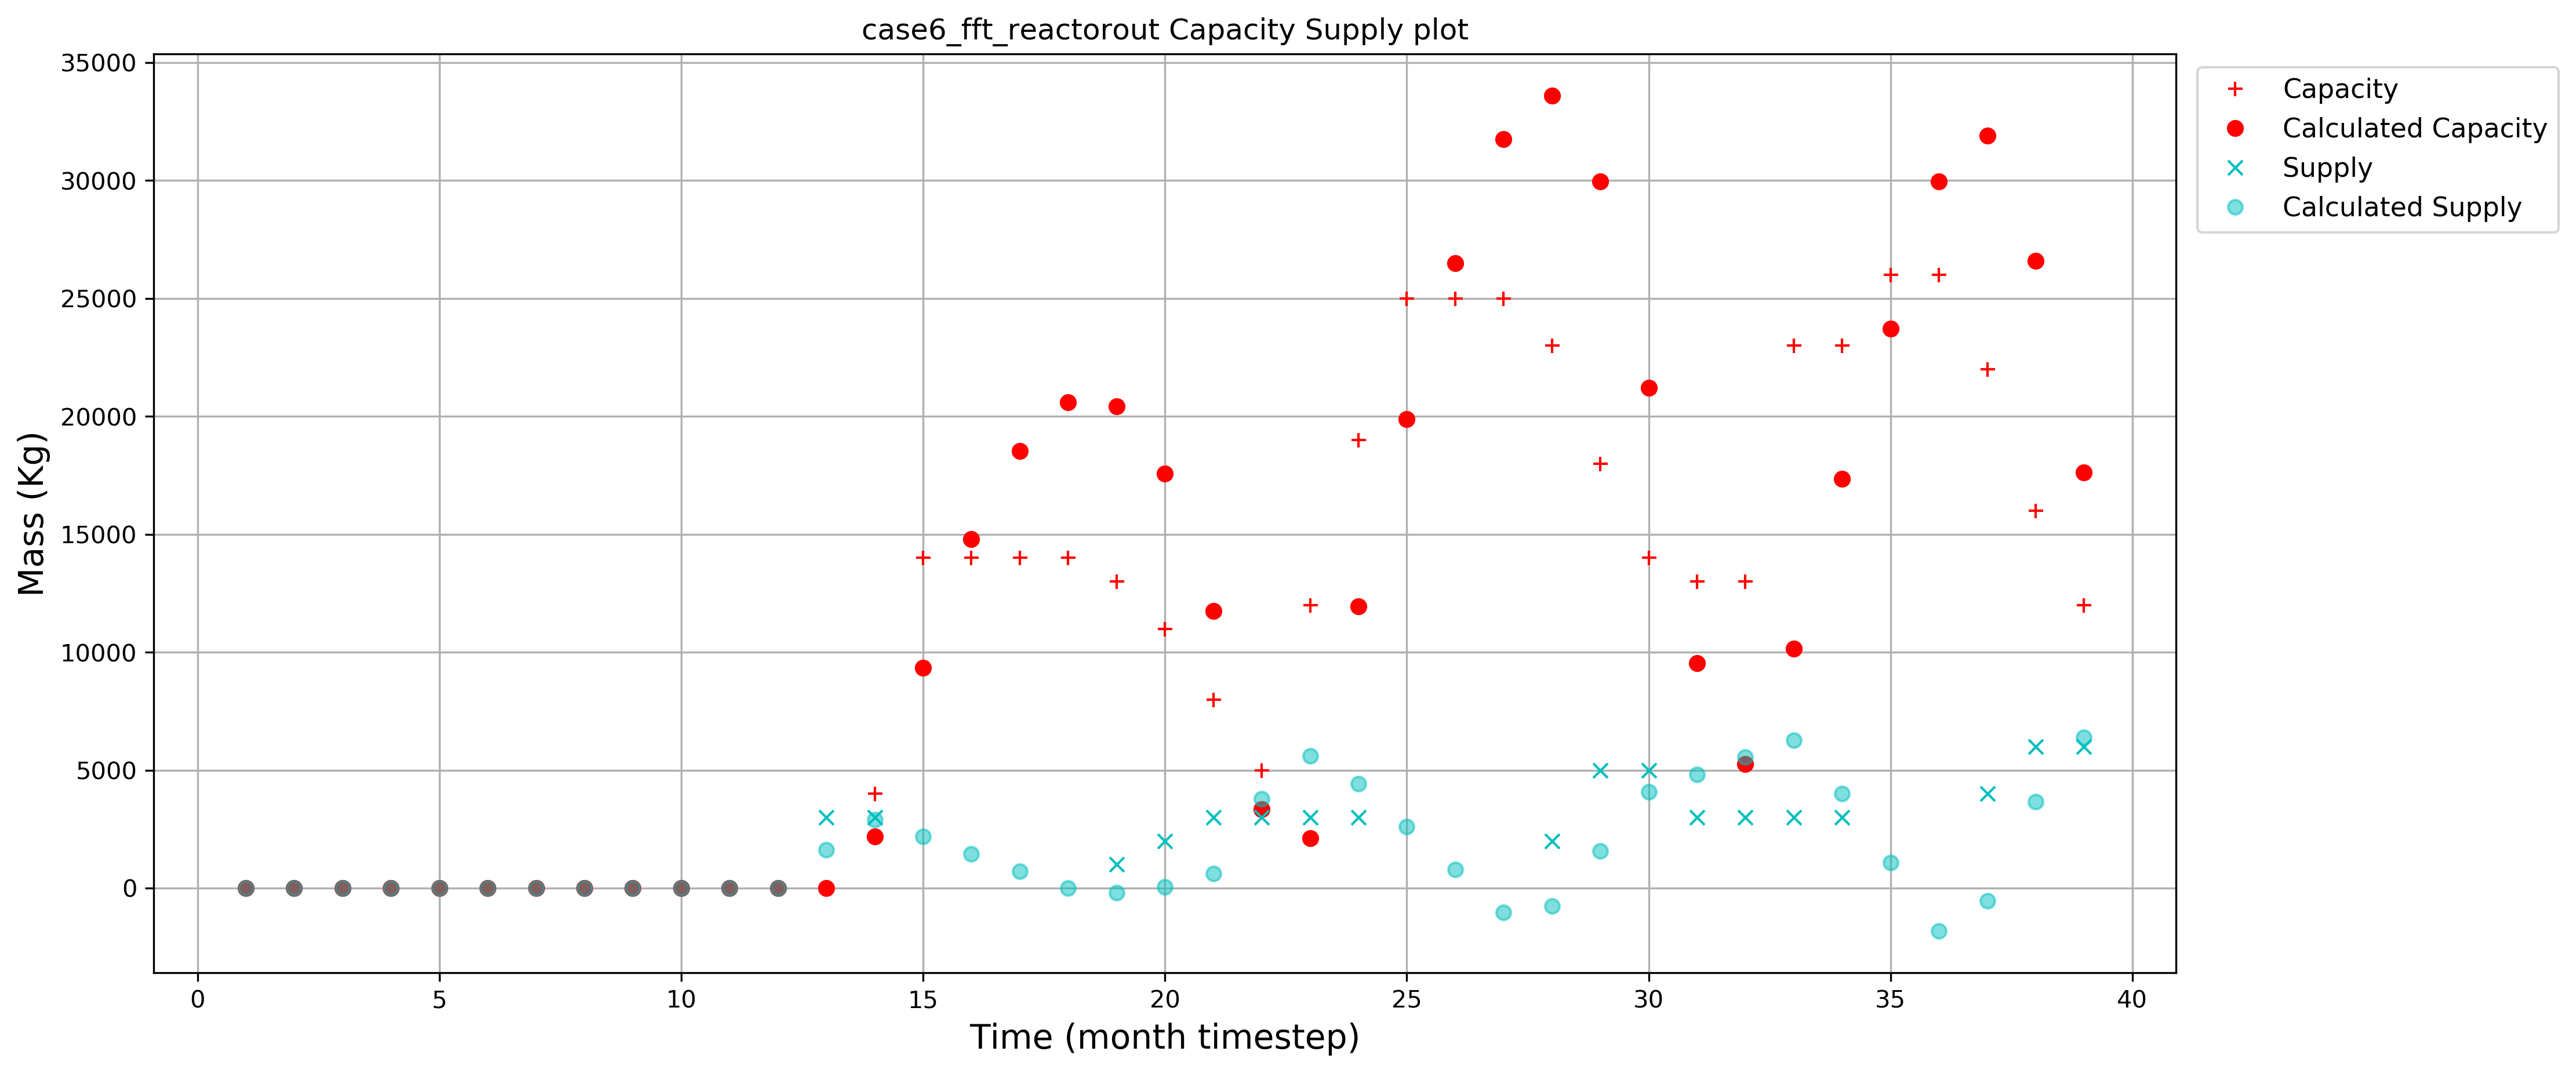

In [6]:
from IPython.display import Image
from IPython.display import display

#I1 = Image(filename='case6_ma_sourceout.png')
#I2 = Image(filename='case6_arma_sourceout.png')
#I3 = Image(filename='case6_arch_sourceout.png')
#I4 = Image(filename='case6_poly_sourceout.png')
#I5 = Image(filename='case6_exp_smoothing_sourceout.png')
#I6 = Image(filename='case6_holt_winters_sourceout.png')
#I7 = Image(filename='case6_fft_sourceout.png')

I8 = Image(filename='case6_ma_power.png')
I9 = Image(filename='case6_arma_power.png')
I10 = Image(filename='case6_arch_power.png')
I11 = Image(filename='case6_poly_power.png')
I12 = Image(filename='case6_exp_smoothing_power.png')
I13 = Image(filename='case6_holt_winters_power.png')
I14 = Image(filename='case6_fft_power.png')
I15 = Image(filename='case6_ma_reactorout.png')
I16 = Image(filename='case6_arma_reactorout.png')
I17 = Image(filename='case6_arch_reactorout.png')
I18 = Image(filename='case6_poly_reactorout.png')
I19 = Image(filename='case6_exp_smoothing_reactorout.png')
I20 = Image(filename='case6_holt_winters_reactorout.png')
I21 = Image(filename='case6_fft_reactorout.png')
display(I8,I9,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19,I20,I21)
#display(I8,I9,I15,I16)


In [7]:
df

,power_residuals,power_chi2,power_undersupply,sourceout_residuals,sourceout_chi2,sourceout_undersupply,reactorout_residuals,reactorout_chi2,reactorout_undersupply,coolout_residuals,coolout_chi2,coolout_undersupply
arch,0.979230,10880.157652,0,-22.507692,2.645557e+06,3,-0.574316,70871.159396,6,-0.121916,190010.000000,1
arma,0.972306,15269.443367,1,-20.332301,2.696666e+06,3,-0.433891,60939.224664,5,-0.109360,288040.000000,1
exp_smoothing,0.974522,18896.825397,0,-8.484326,9.508442e+05,2,-0.372463,104323.075652,3,-0.136271,190000.000000,1
fft,0.956244,8423.052445,11,-9.636977,1.388029e+06,1,0.556262,42839.243651,1,-0.132454,194000.000000,1
holt_winters,0.974522,18896.825397,0,-8.484326,9.508442e+05,2,-0.372463,104323.075652,3,-0.136271,190000.000000,1
ma,0.999290,1083.333333,1,-13.655680,5.926401e+05,2,-0.516842,69137.201687,4,-0.252943,380031.052632,1
poly,0.984864,3317.556485,18,-1.601130,8.009281e+05,4,0.298703,44419.463869,4,-0.259774,384020.833333,1
